# Reinforcement Learning hans-on by OpenAI Gym

必要なモジュールをインストール

In [1]:
# OpenAIGym環境
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# notebook内で環境表示するためのモジュール
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

# 強化学習のためのモジュール
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam
from rl.core import Processor
from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory

Using TensorFlow backend.


notebook内に動画を表示する関数を定義

In [2]:
# 参考: https://book.mynavi.jp/manatee/detail/id=88961
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    # plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))

シミュレーション環境を定義([Pendulum-v0](https://gym.openai.com/envs/Pendulum-v0/))

In [3]:
env = gym.make('Pendulum-v0')

[GitHubのWiki](https://github.com/openai/gym/wiki)で環境の情報を確認する

環境情報を確認してみる

In [4]:
observation = env.reset()
print(observation)

[-0.63731035 -0.77060724  0.65377332]


とれるActionを確認してみる

In [5]:
action = env.action_space.sample()
print(action)

[0.19525401]


行動を起こし、環境を変化させてみる

In [6]:
observation, reward, done, info = env.step(action)
print('observation', observation)
print('reward', reward)
print('done', done)
print('info', info)

observation [-0.6332518  -0.77394584  0.10510599]
reward -5.158515847552596
done False
info {}


ランダム行動で1エピソード動かしてどのように動いたかを確認する


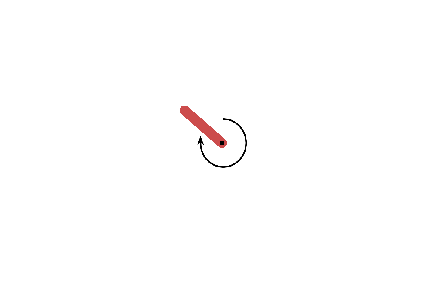
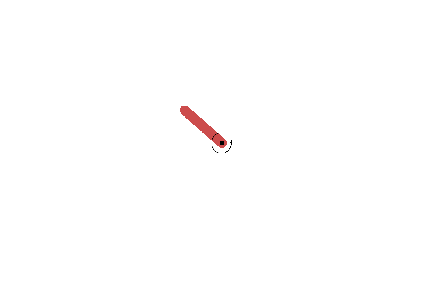
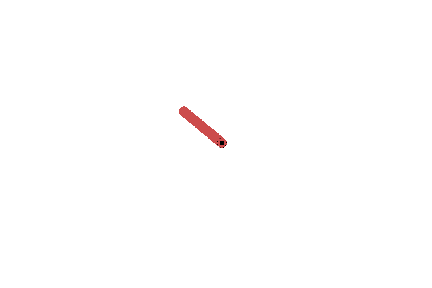
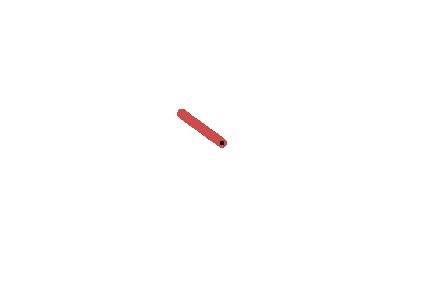
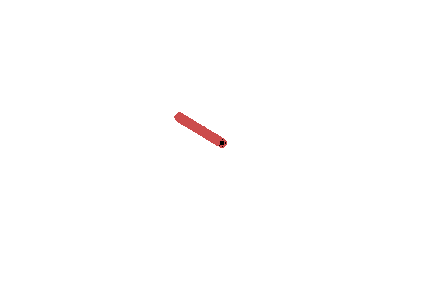
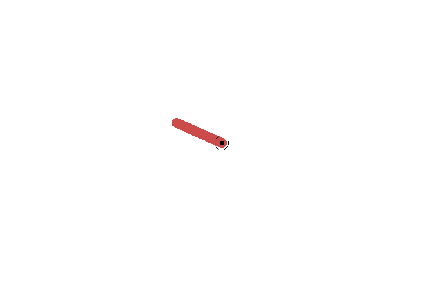
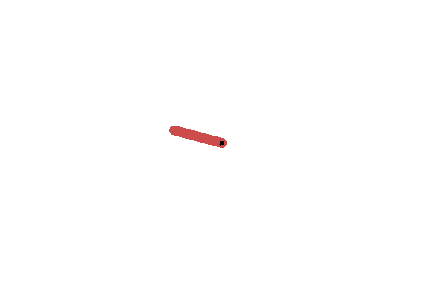
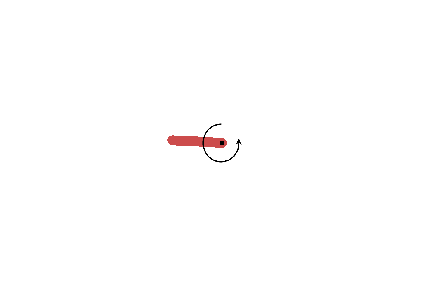
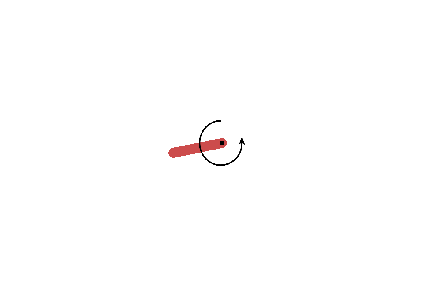
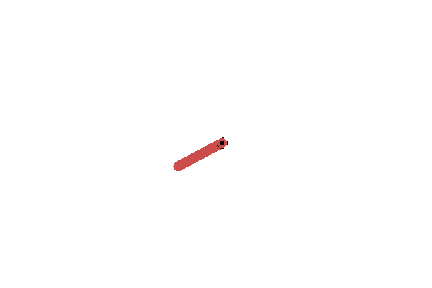
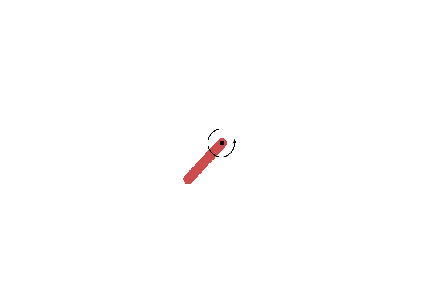
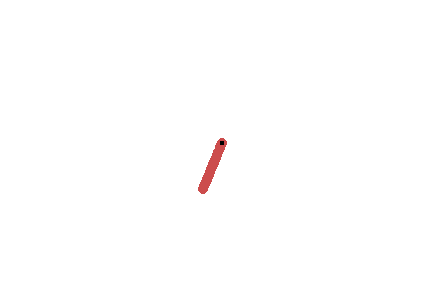
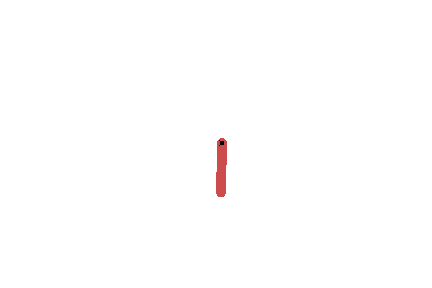
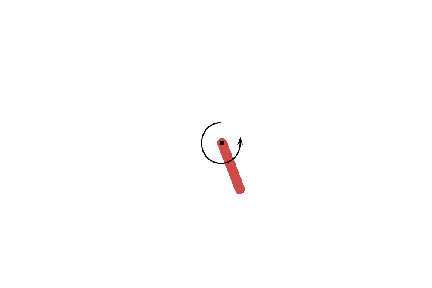
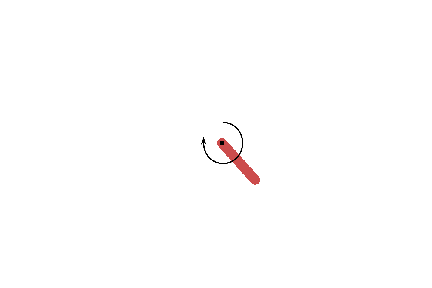
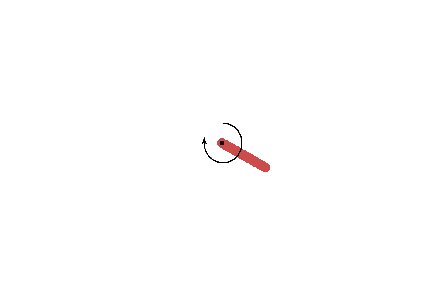
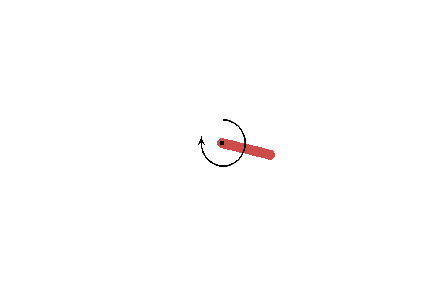
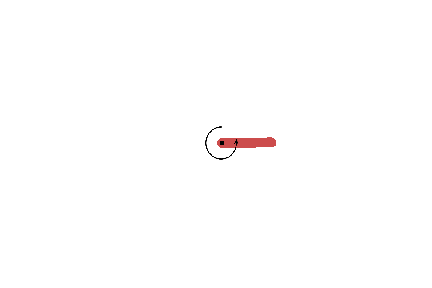
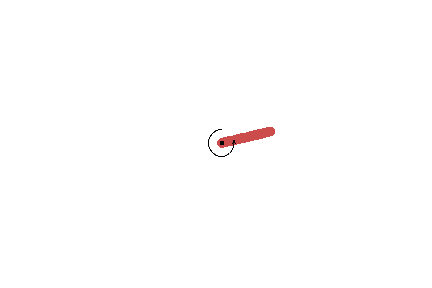
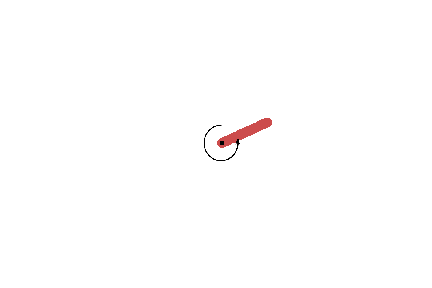
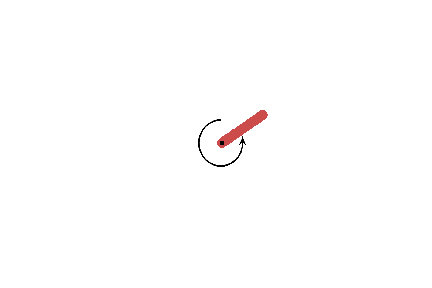
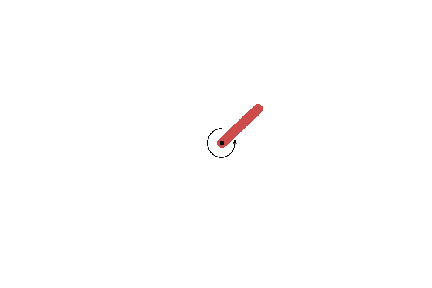
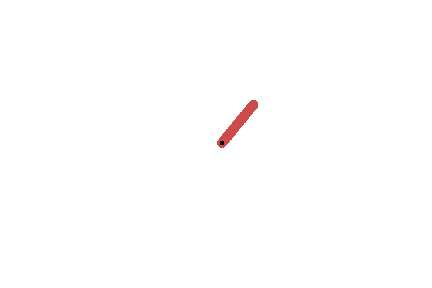
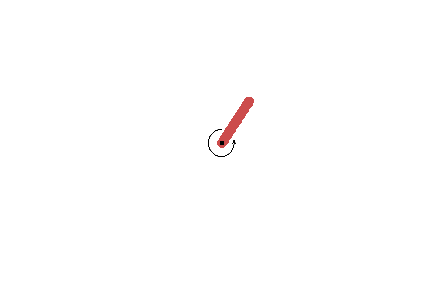
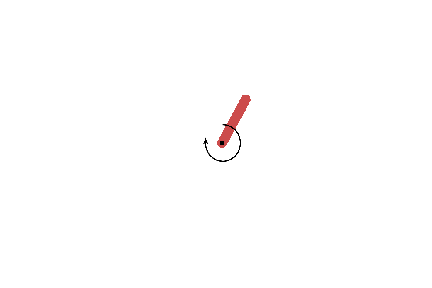
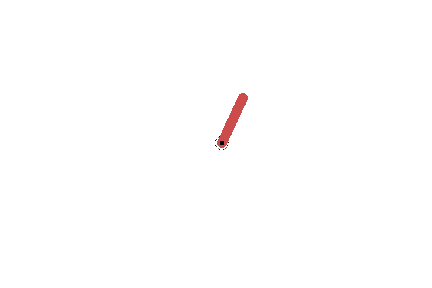
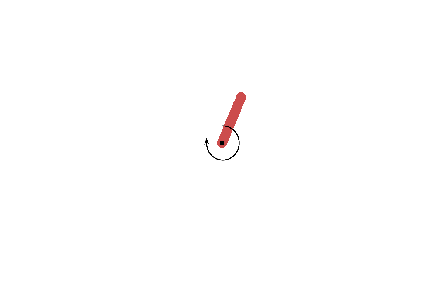
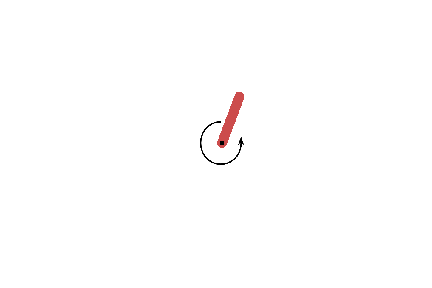
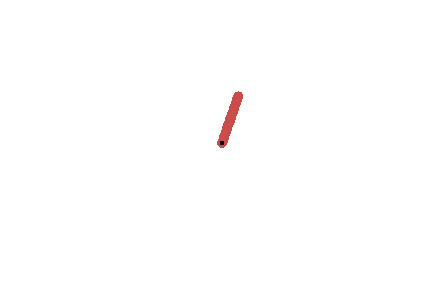
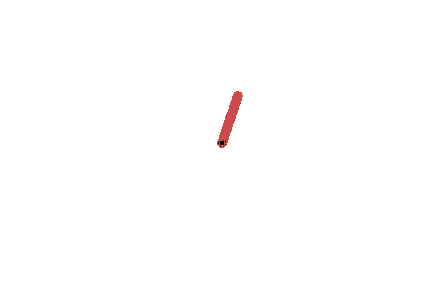
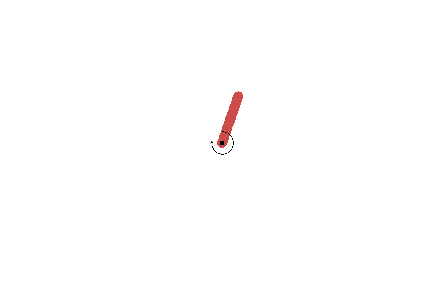
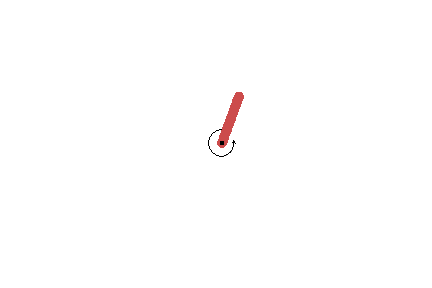
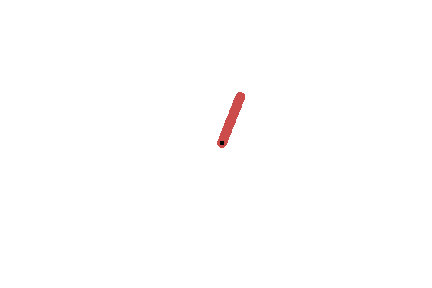
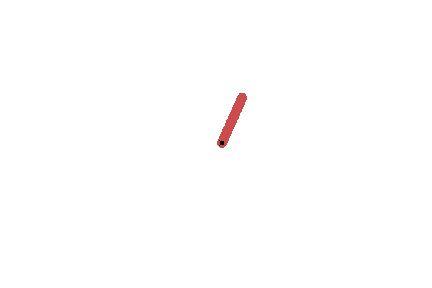
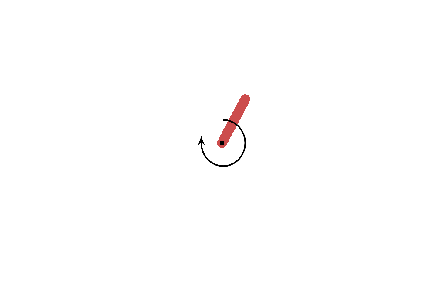
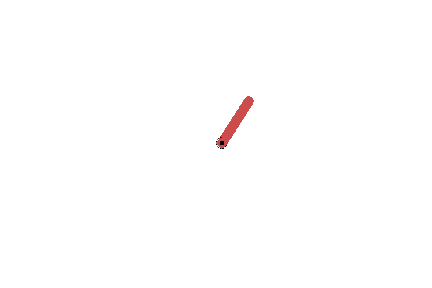
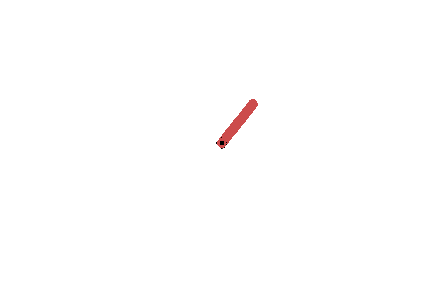
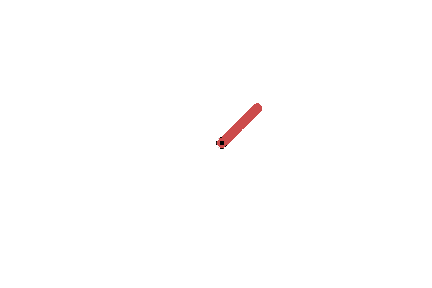
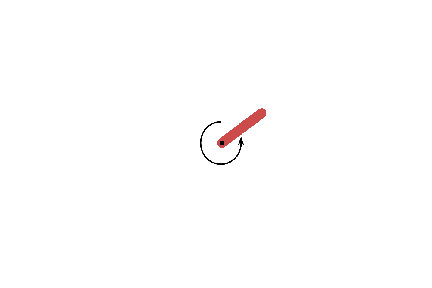
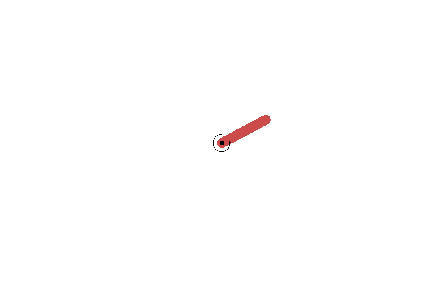
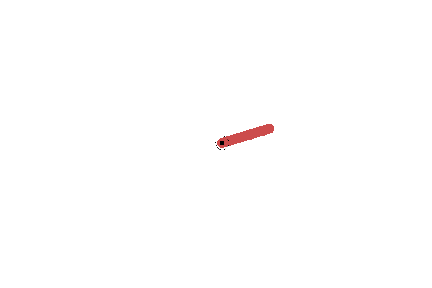
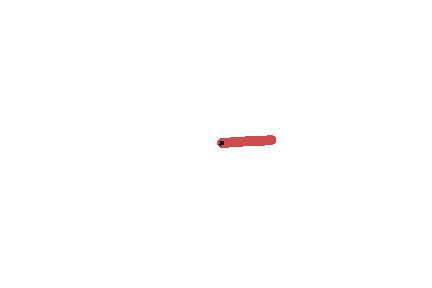
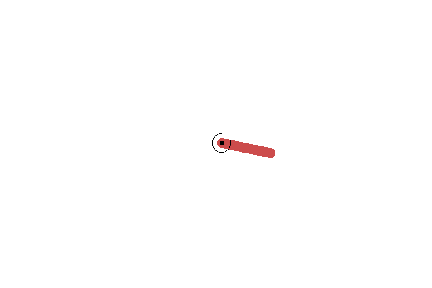
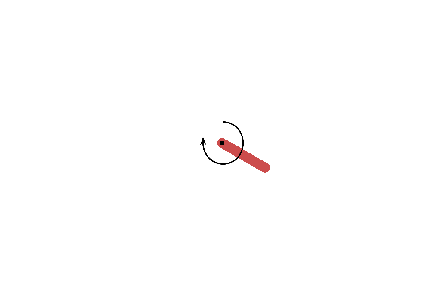
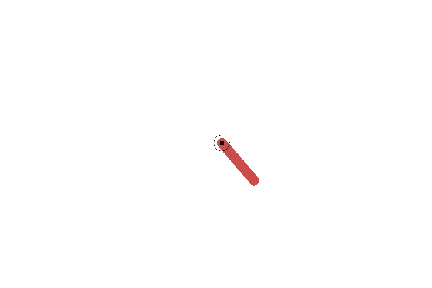
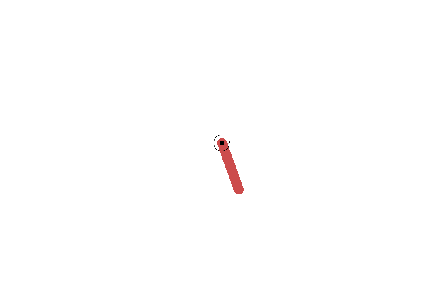
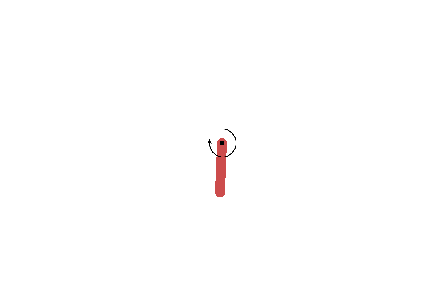
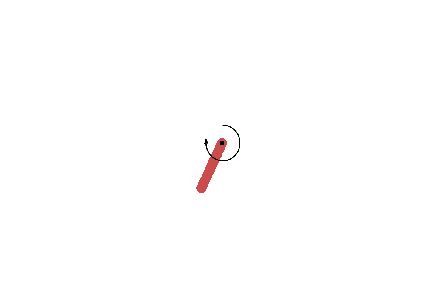
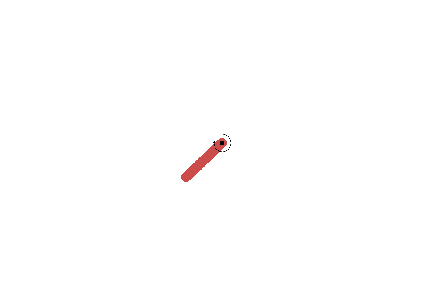
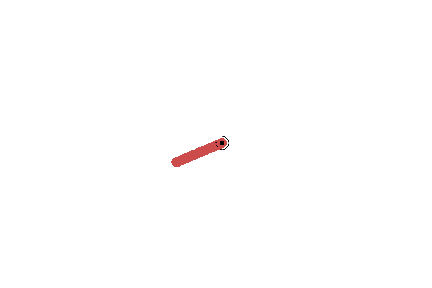
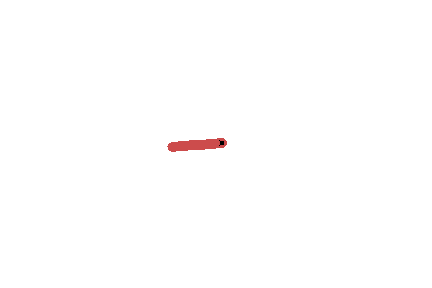
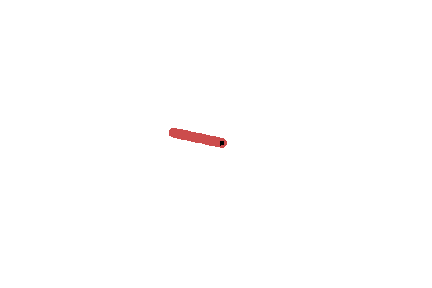
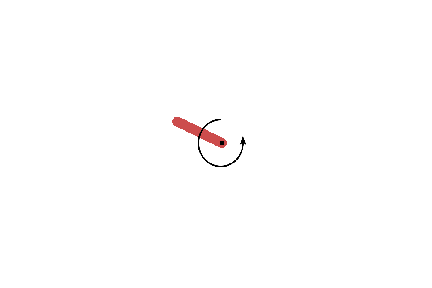
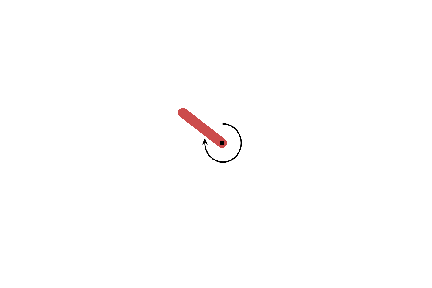
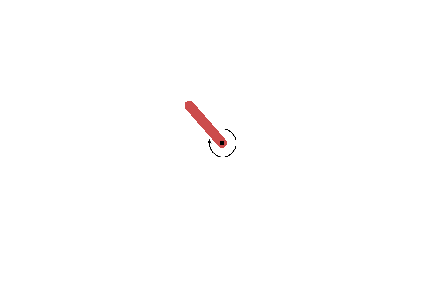
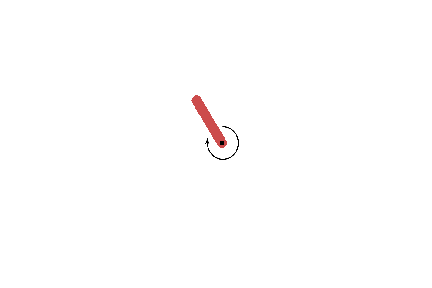
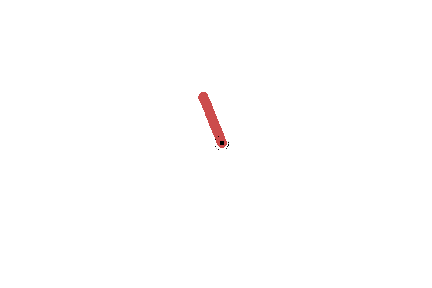
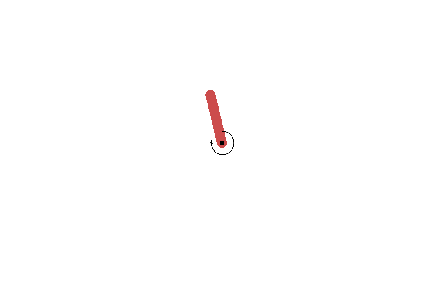
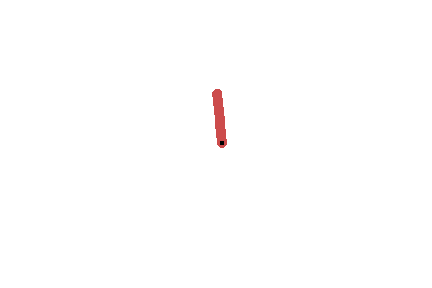
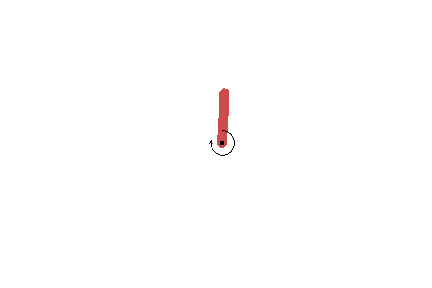
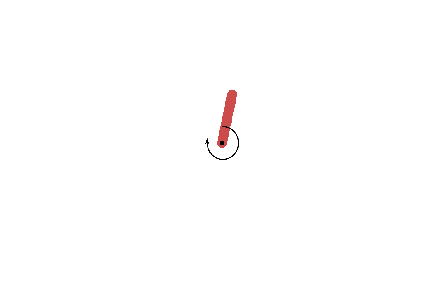
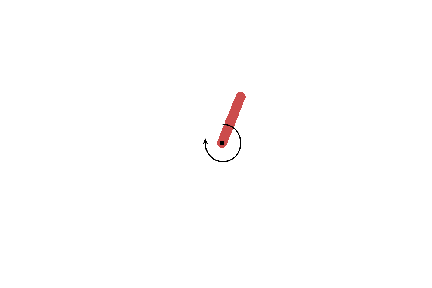
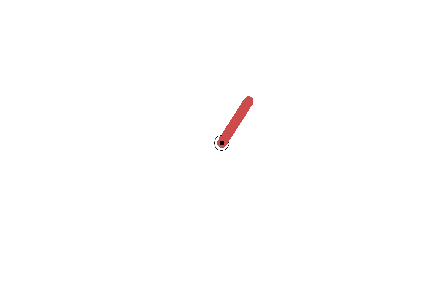
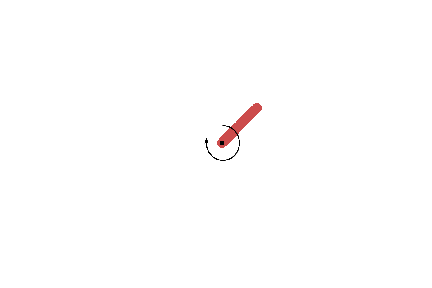
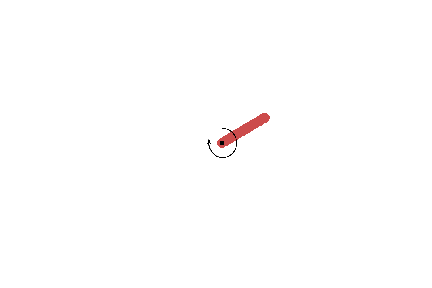
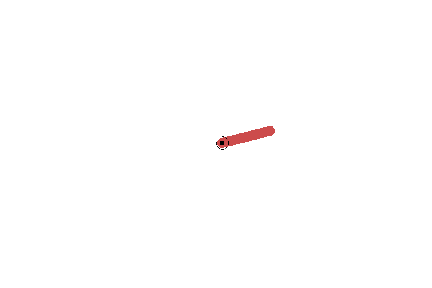
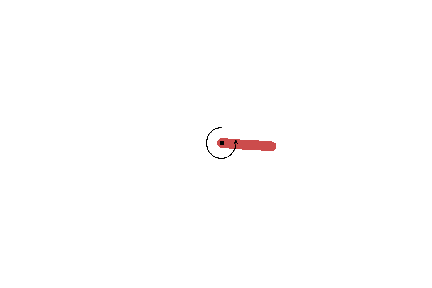
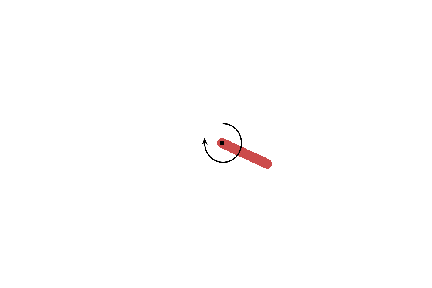
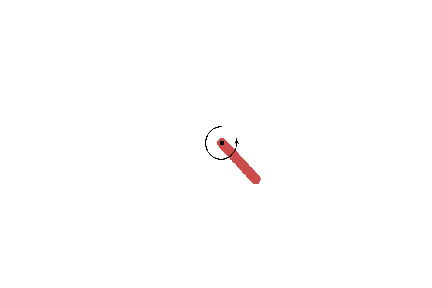
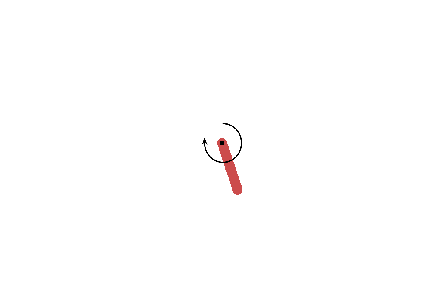
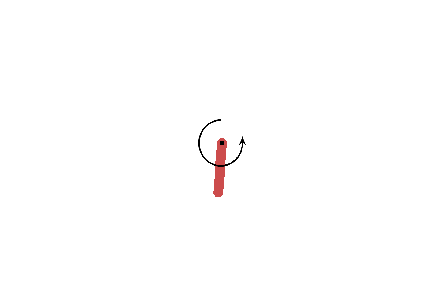
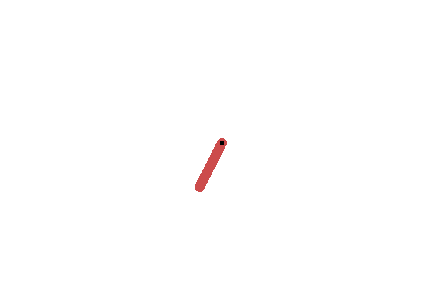
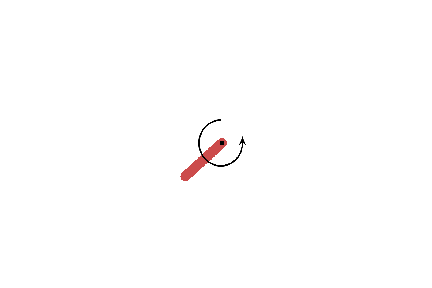
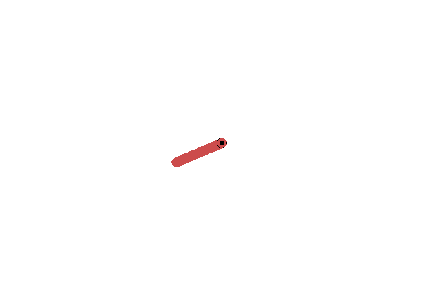
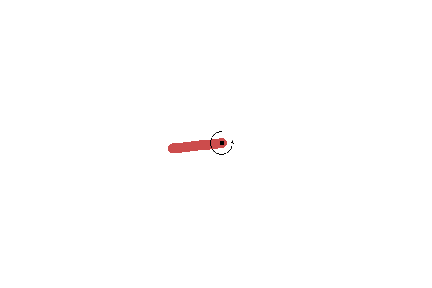
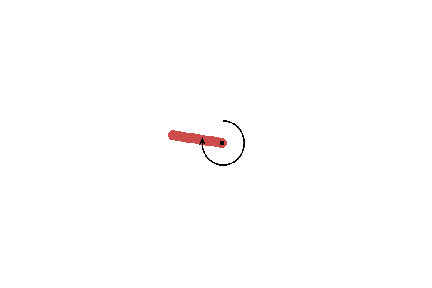
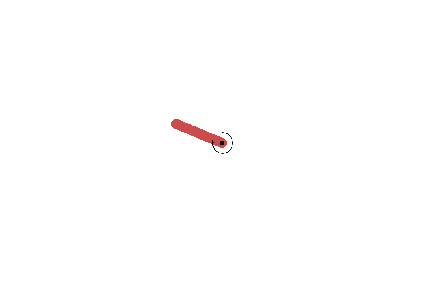
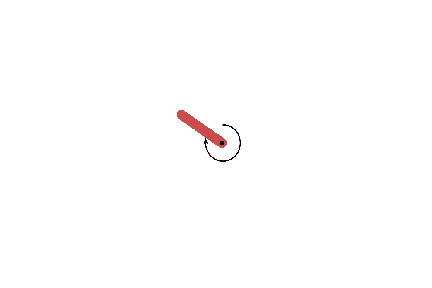
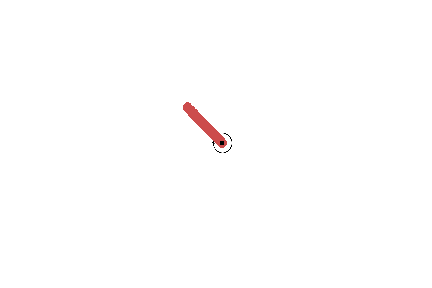
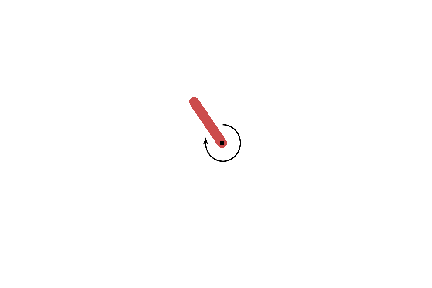
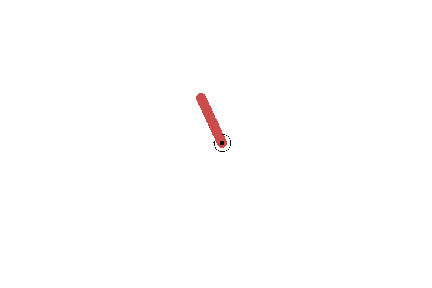
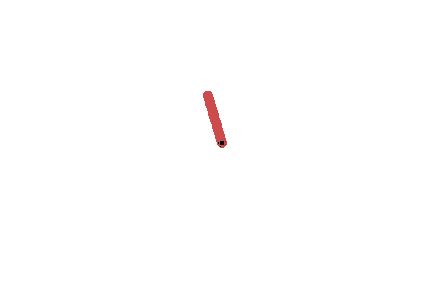
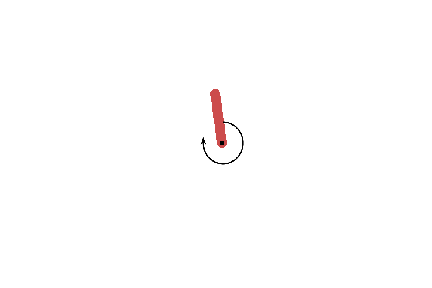
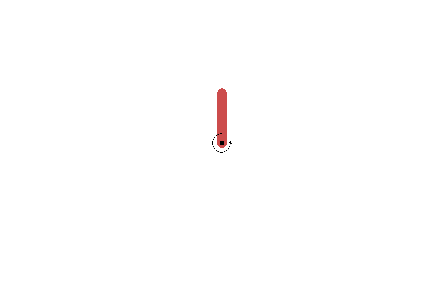
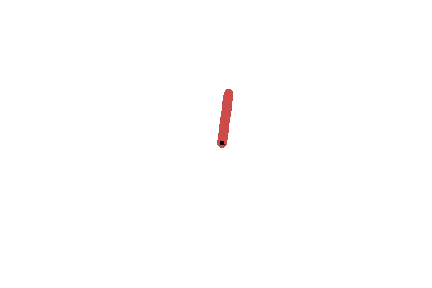
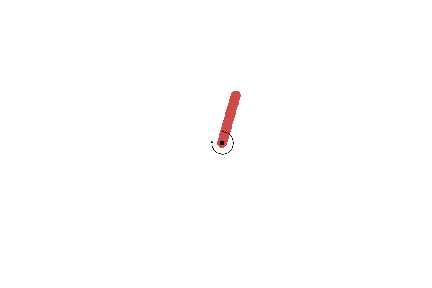
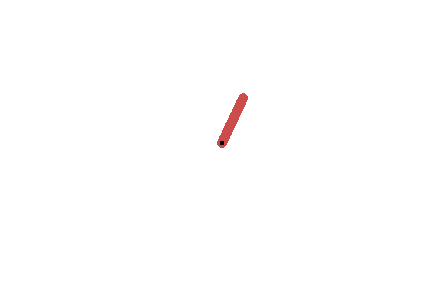
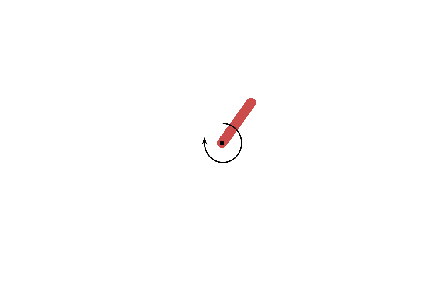
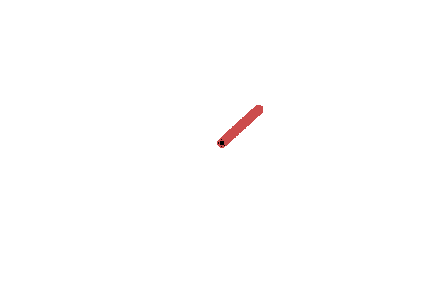
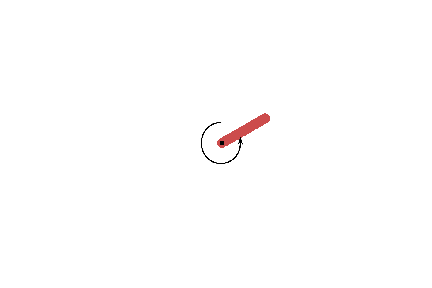
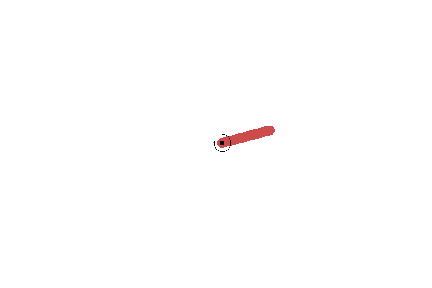
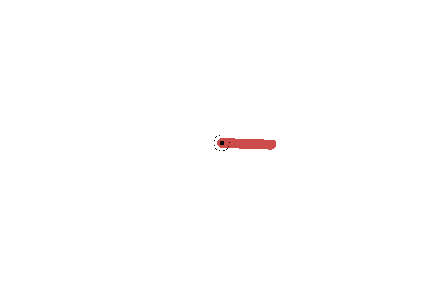
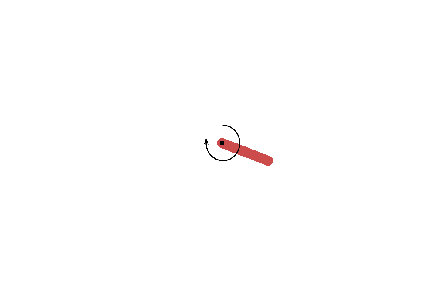
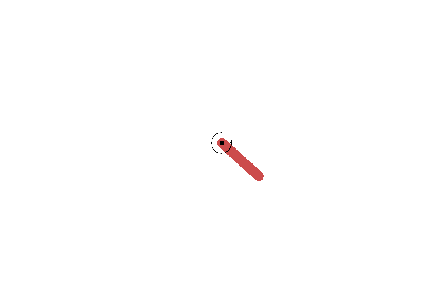
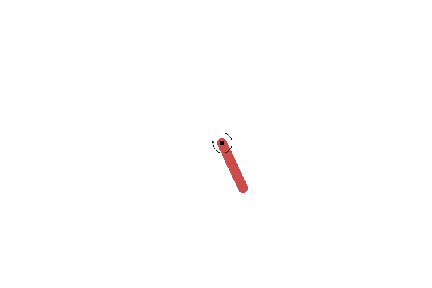
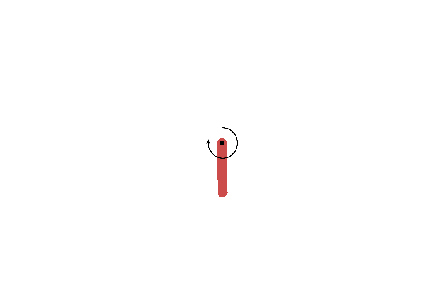
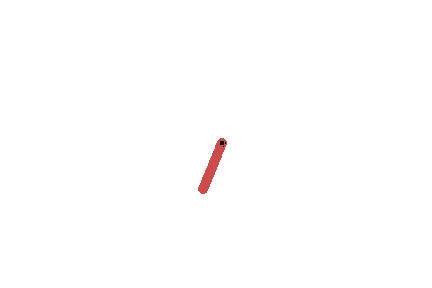
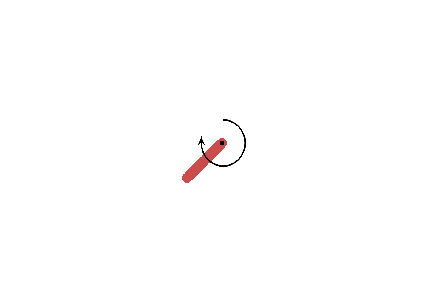
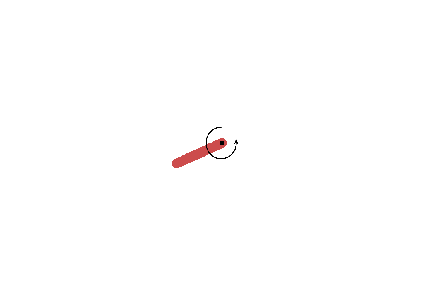
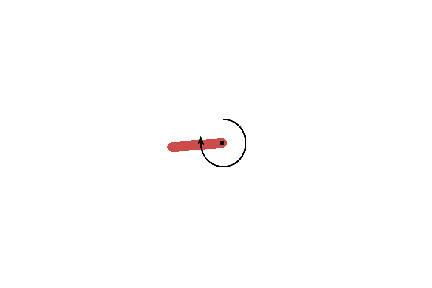
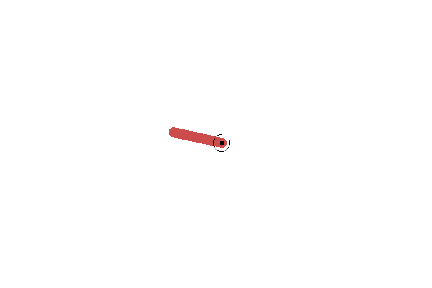
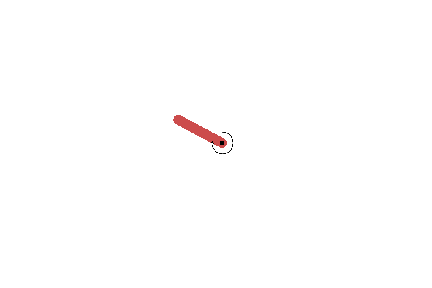
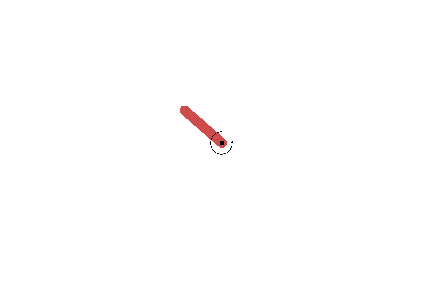
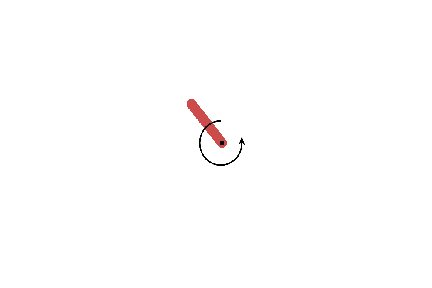
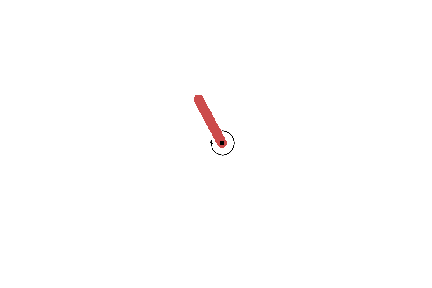
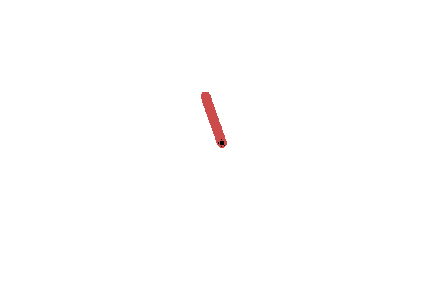
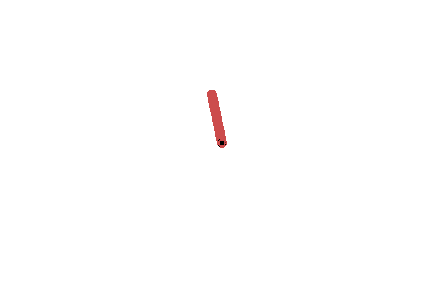
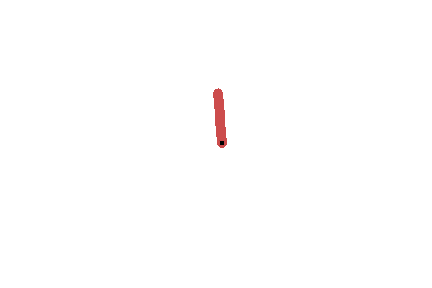
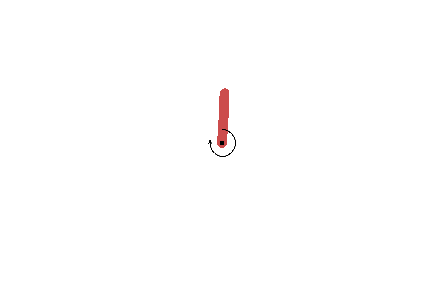
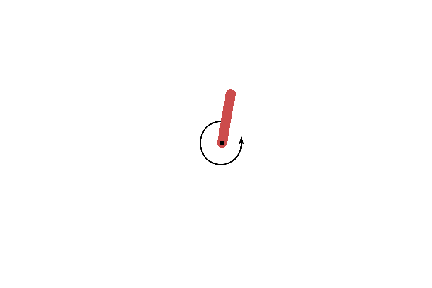
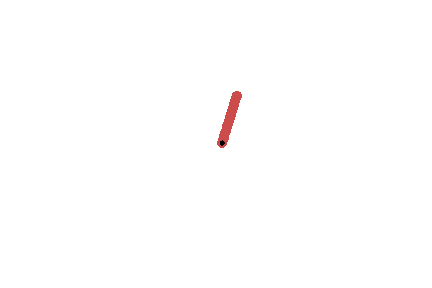
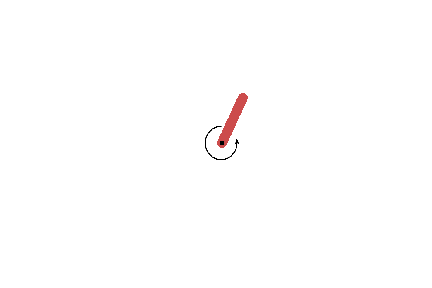
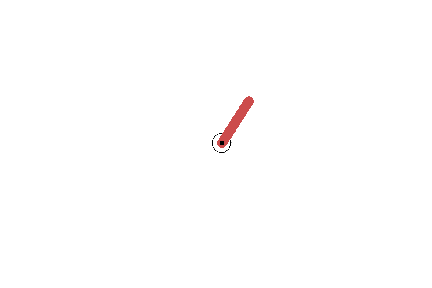
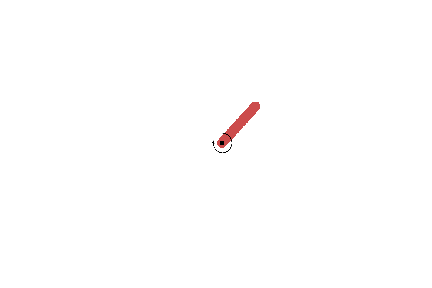
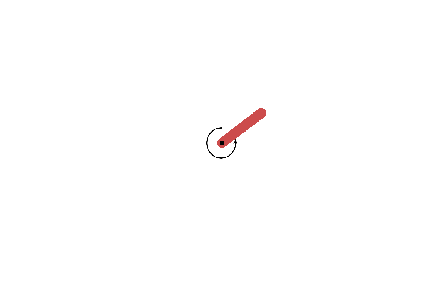
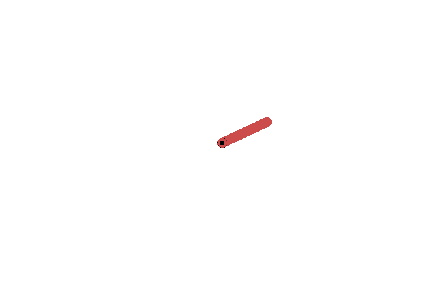
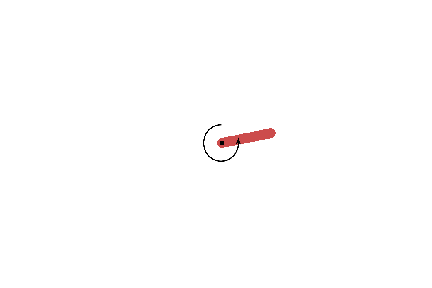
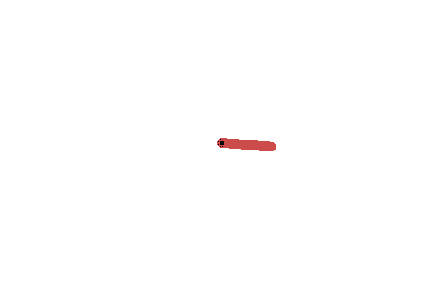
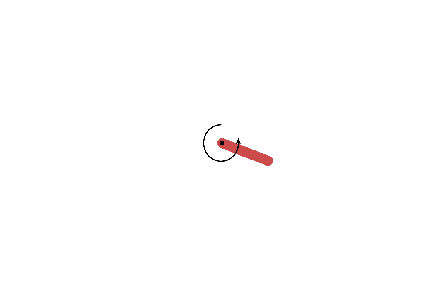
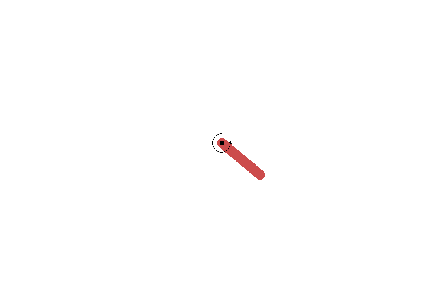
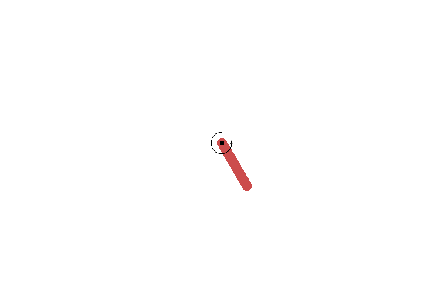
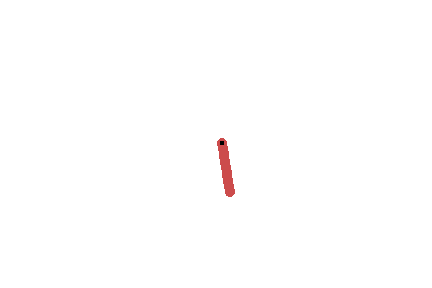
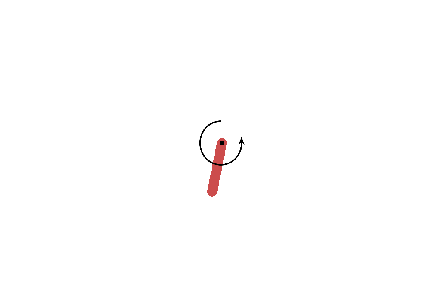
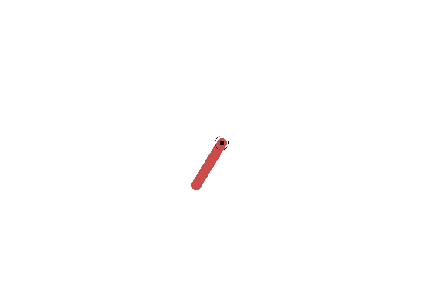
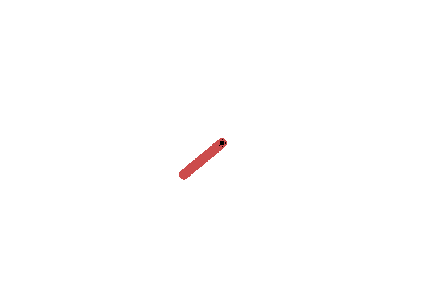
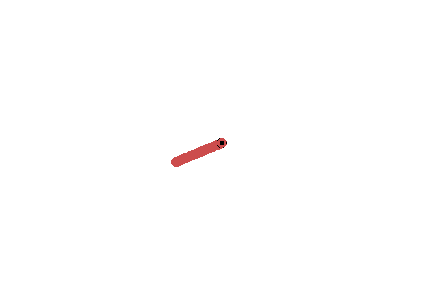
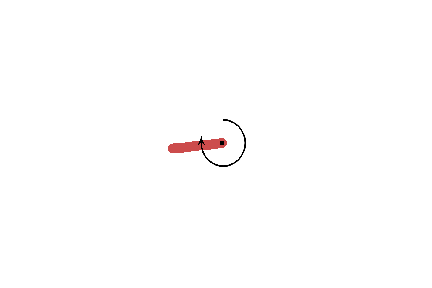
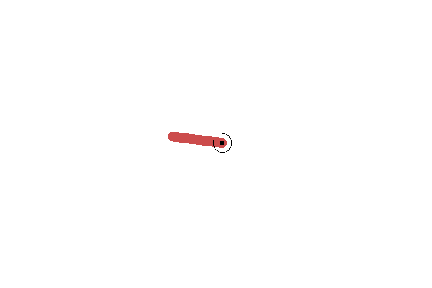
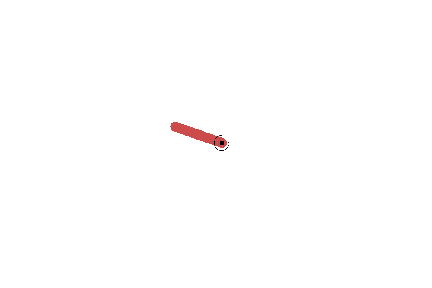
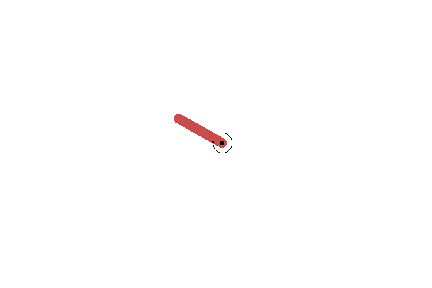
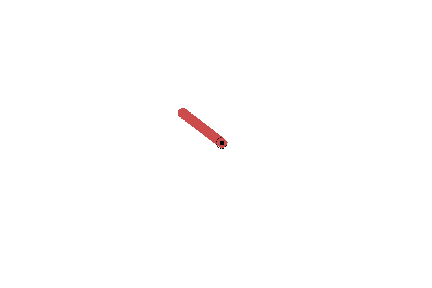
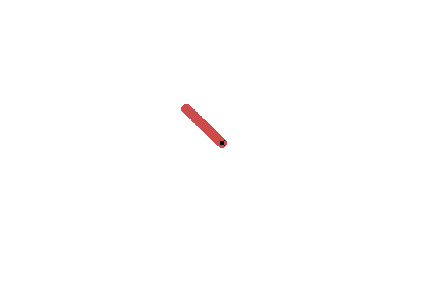
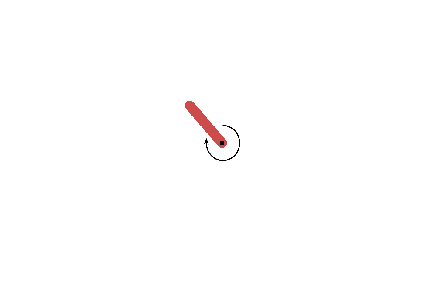
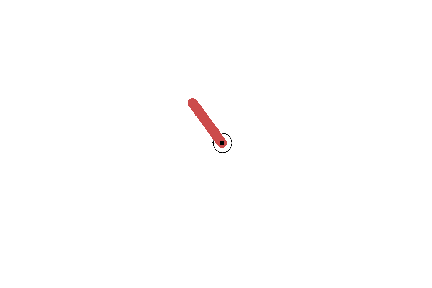
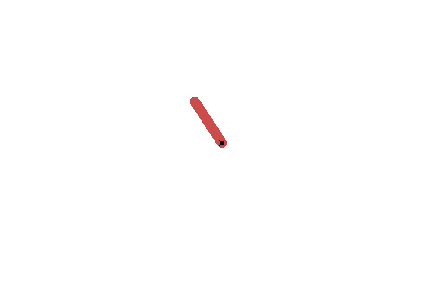
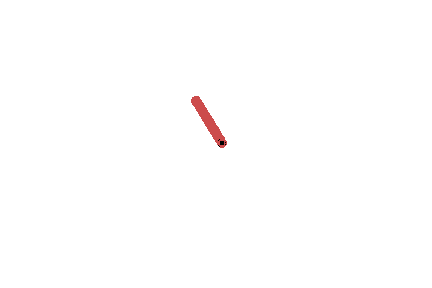
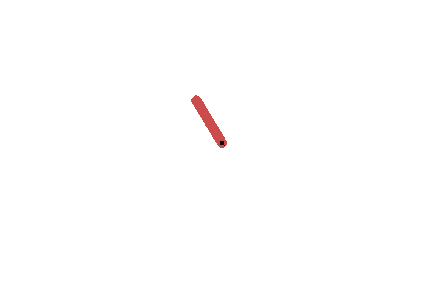
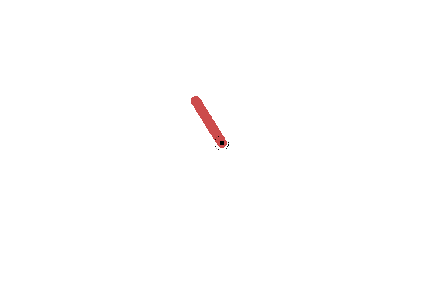
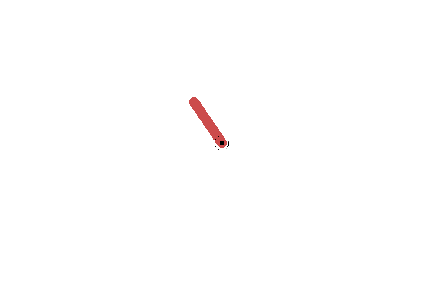
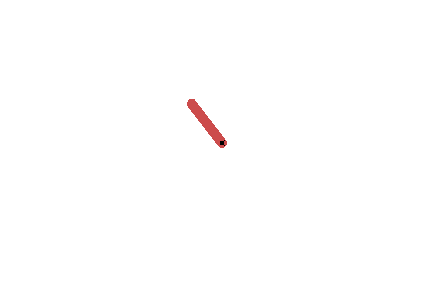
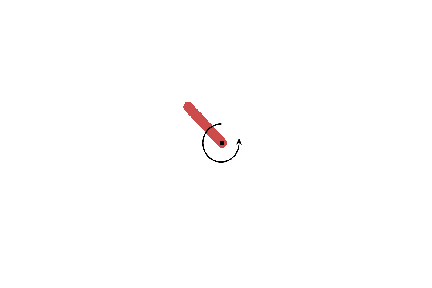
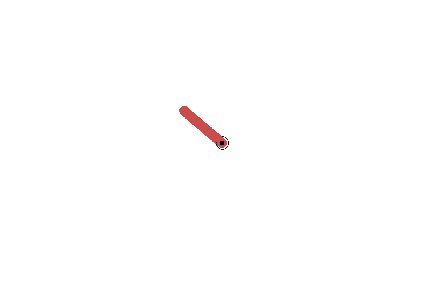
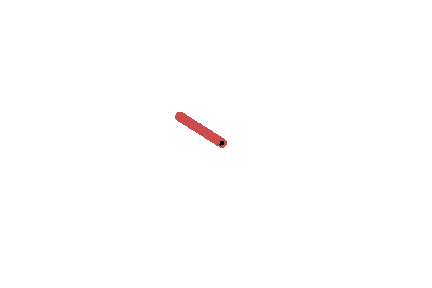
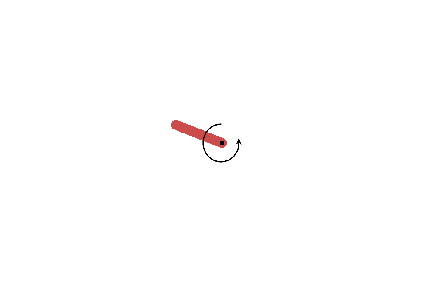
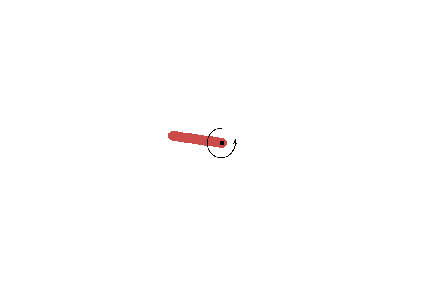
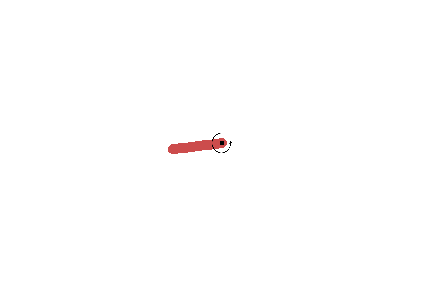
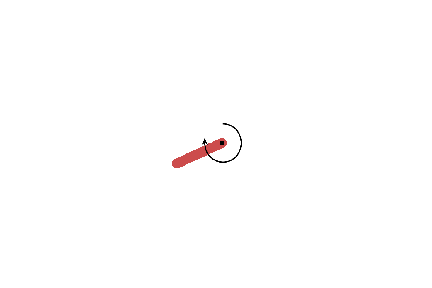
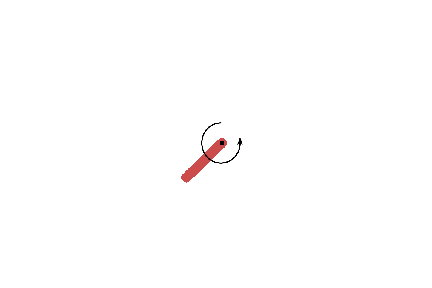
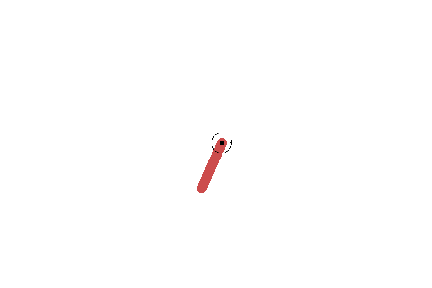
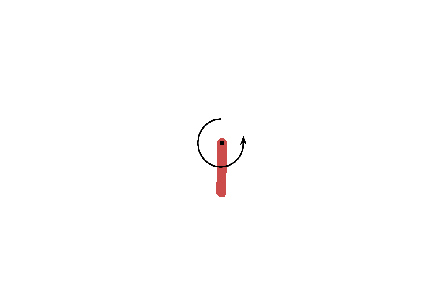
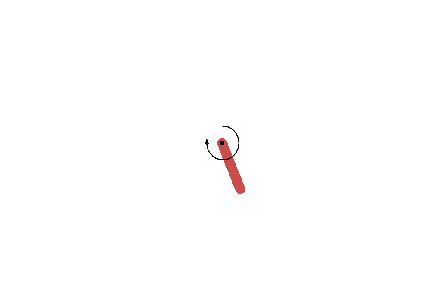
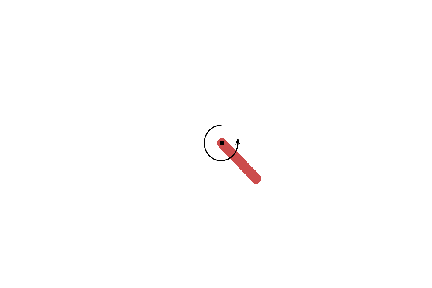
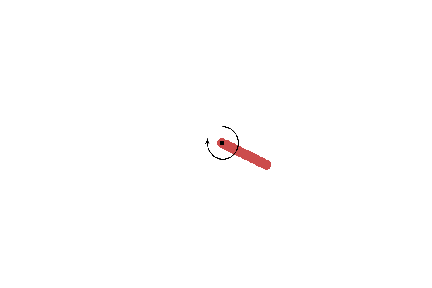
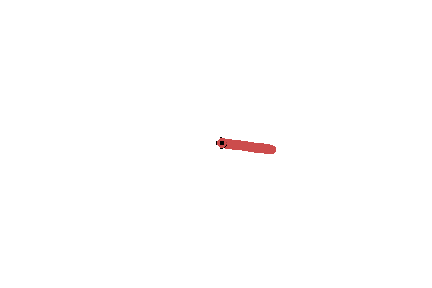
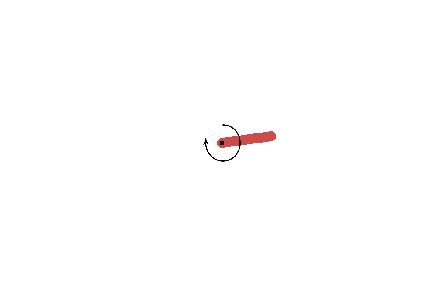
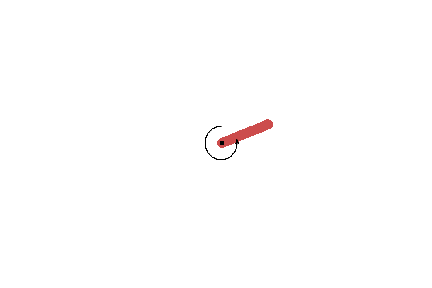
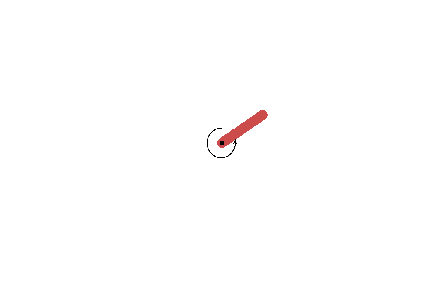
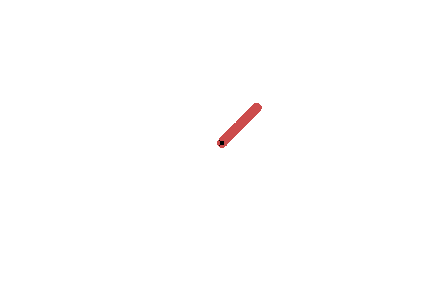
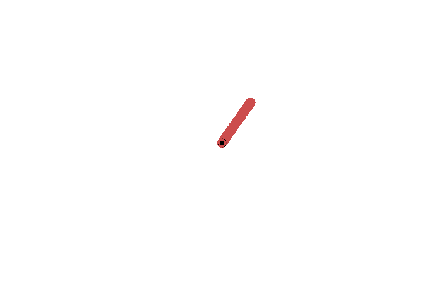
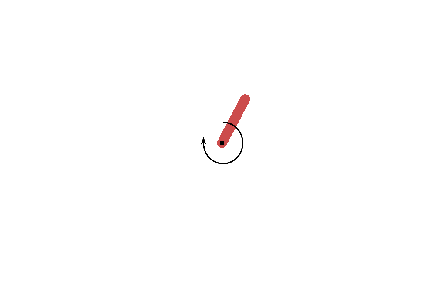
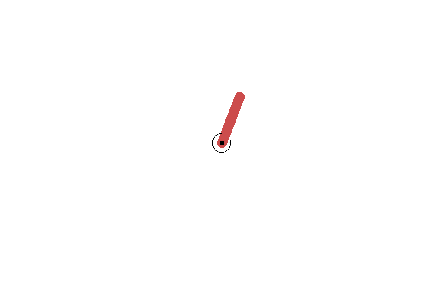
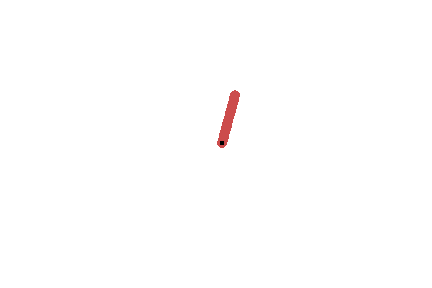
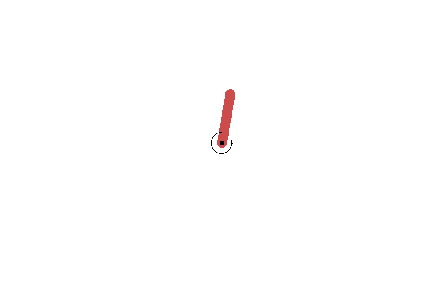
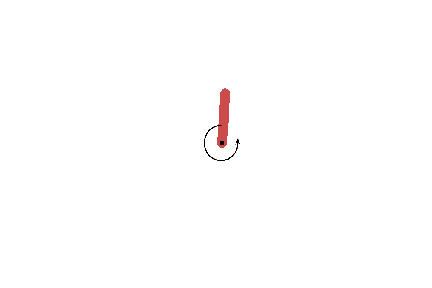
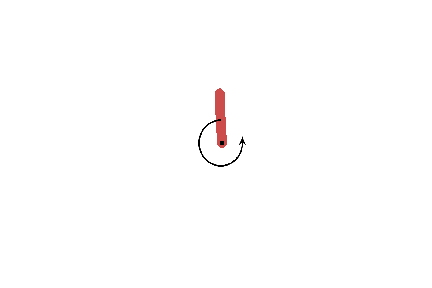
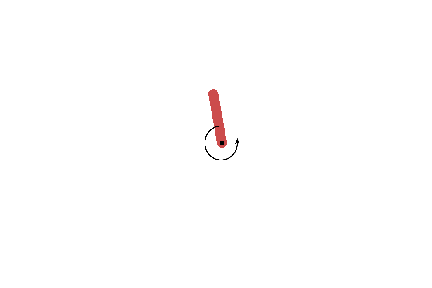
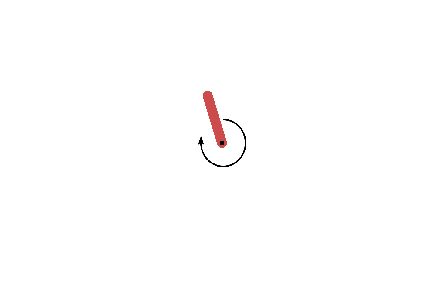
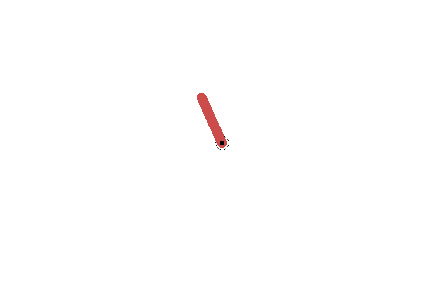
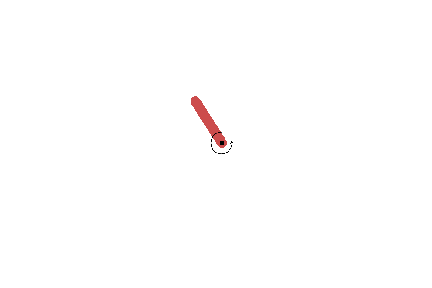
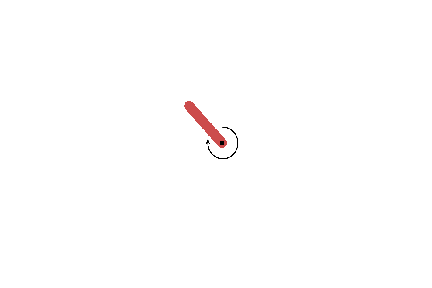
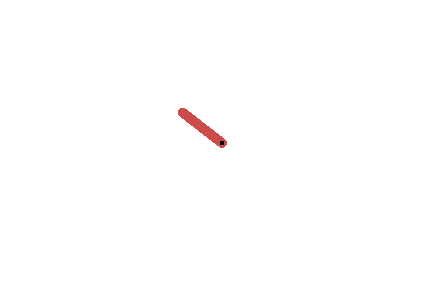
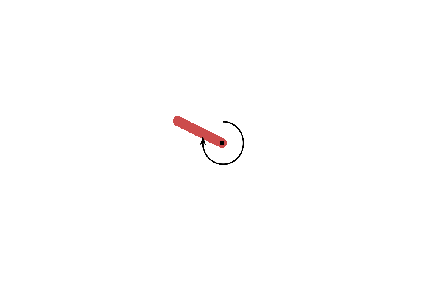
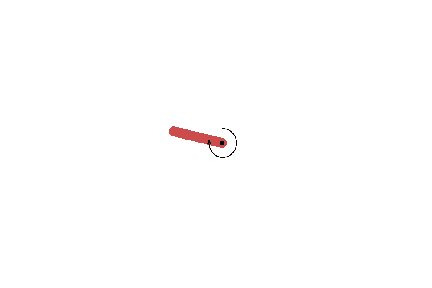
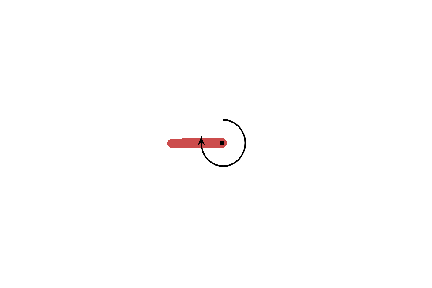
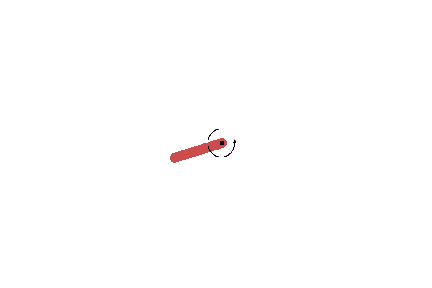
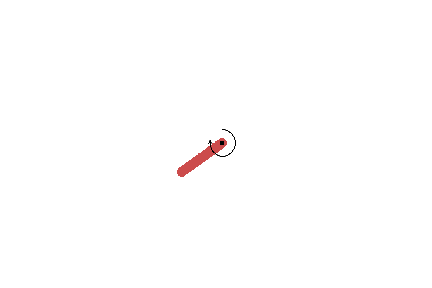
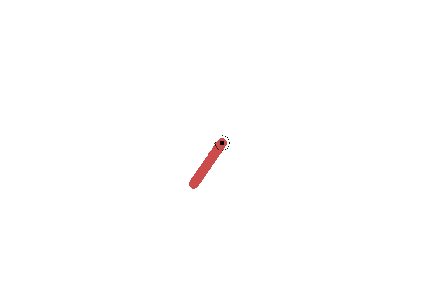
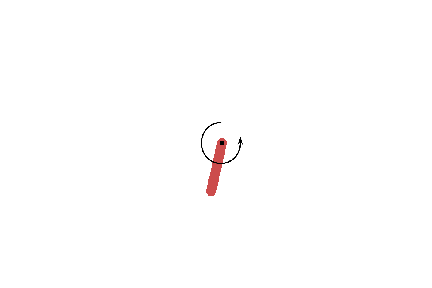
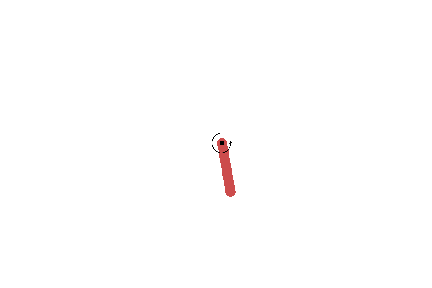
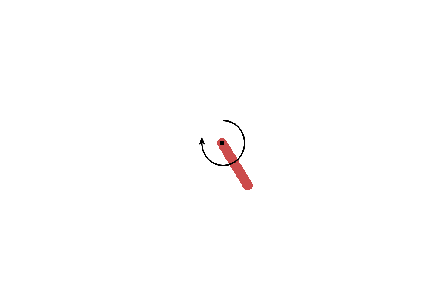
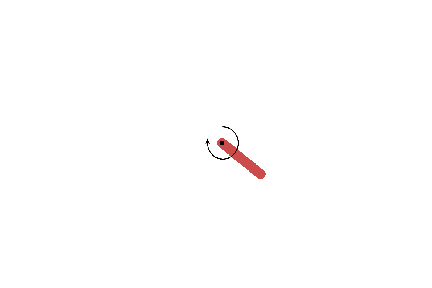
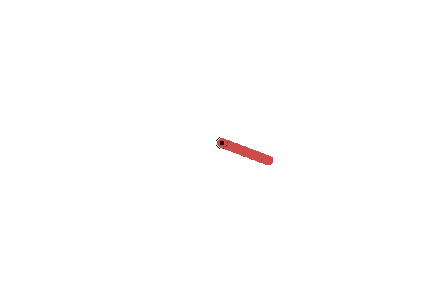
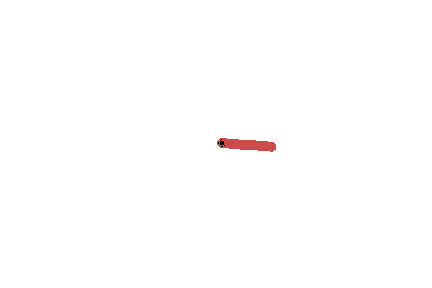
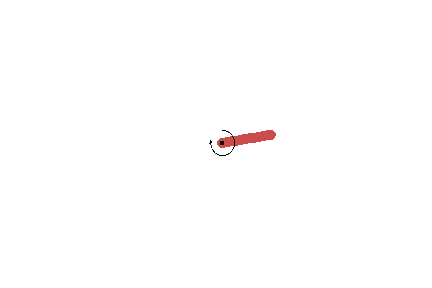
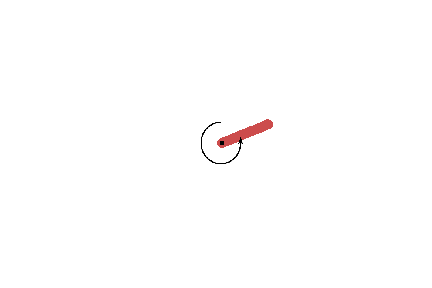
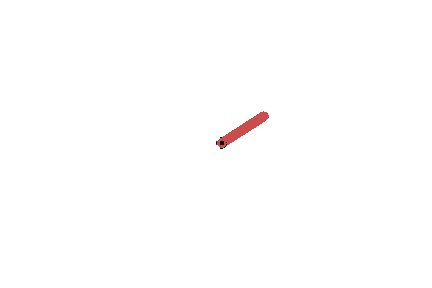
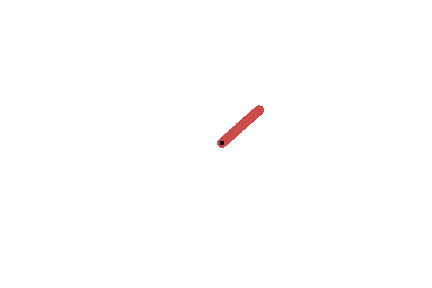
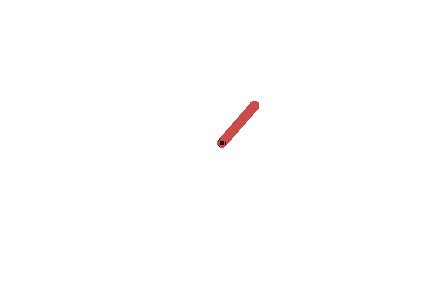
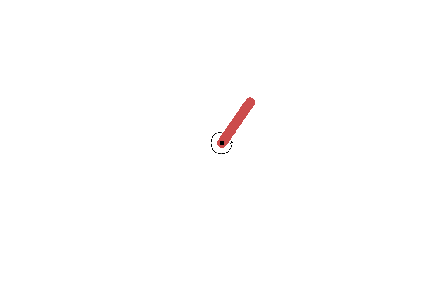
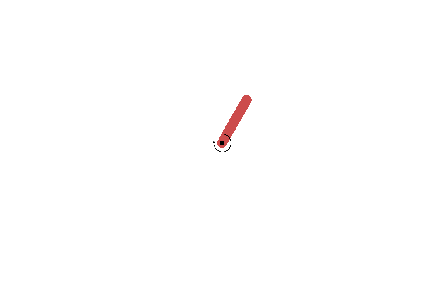
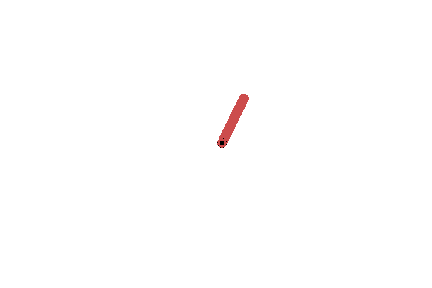
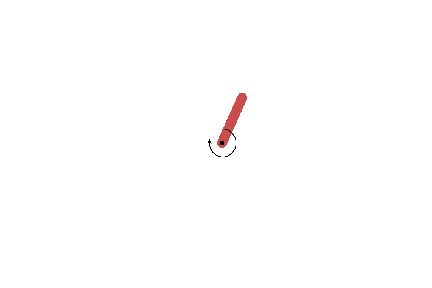
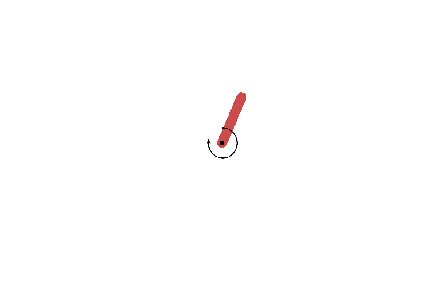
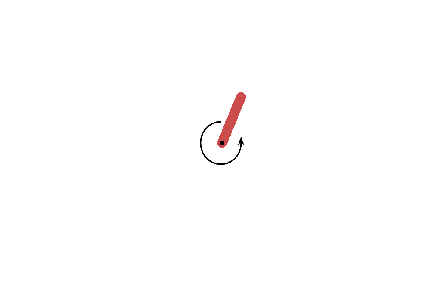
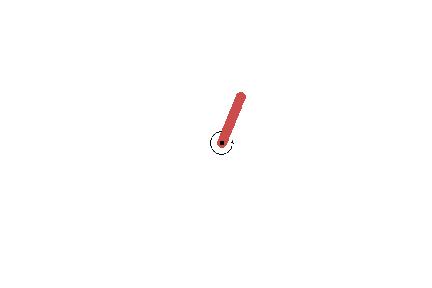
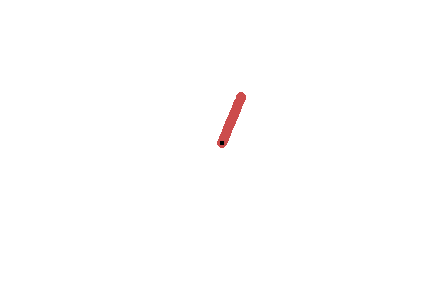
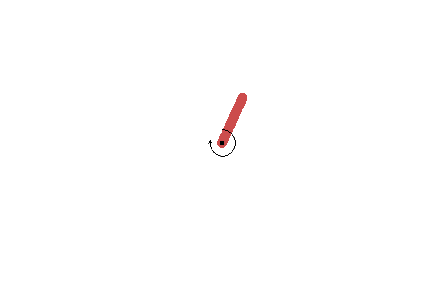
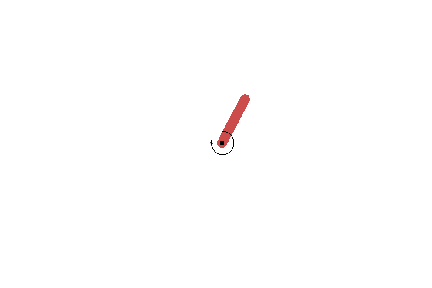
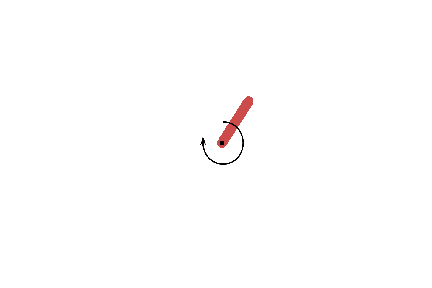
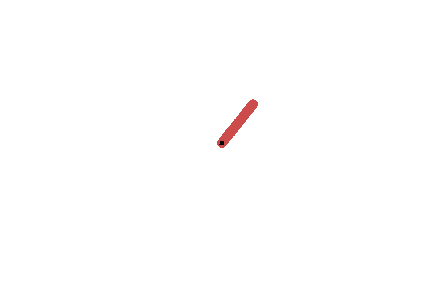

In [7]:
observation = env.reset()  # 環境はリセットする
frames = []  # 環境情報
while True:
    frames.append(env.render(mode='rgb_array'))
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done:
        break
env.close()
display_frames_as_gif(frames)

ランダム行動で1エピソード動かして、報酬の最大、最小、平均を計算する  
重くなるので画面表示は行わない

In [8]:
observation = env.reset()  # 環境はリセットする
rewards = []
while True:
    action = env.action_space.sample()
    obs, r, done, _ = env.step(action)  # 変数名は省略する
    rewards.append(r)
    if done:
        break
env.close()
print('MAX', max(rewards))
print('MIN', min(rewards))
print('AVG', sum(rewards)/len(rewards))

MAX -5.634809292998747
MIN -10.418539881318669
AVG -7.901467377307854


## 強化学習モデルの作成

`Pendulum-v0`の環境と、学習アルゴリズムを仲介するクラスを作成

In [9]:
ACT2VAL = {0: [-1], 1: [+1]}  # 行動を右に回す, 左に回すの2択にする

class PendulumProcessor(Processor):

    def __init__(self):
        self.act2val = ACT2VAL 
    
    def process_action(self, action):
        return self.act2val[action]

仲介クラスを定義

In [10]:
processor = PendulumProcessor()

入力の次元数を定義

In [11]:
input_shape = (1,) + env.observation_space.shape
input_shape

(1, 3)

とれる行動数を指定

In [12]:
n_act = 2

##### ニューラルネットワークを定義
全結合2層、ユニット数16

In [13]:
model = Sequential()
model.add(Flatten(input_shape=input_shape))
model.add(Dense(16))
model.add(Activation("relu"))
model.add(Dense(16))
model.add(Activation("relu"))
model.add(Dense(n_act))
model.add(Activation('linear'))

##### メモリーを定義  
1エピソードずつ、50000エピソード経験を保存しておく

In [14]:
memory = SequentialMemory(limit=50000, window_length=1)

##### 探索方針の設定
ε-greedyを使う

In [15]:
policy = EpsGreedyQPolicy(eps=0.01)

##### エージェントの設定

In [16]:
dqn = DQNAgent(model=model,
               nb_actions=n_act,
               memory=memory,
               policy=policy,
               processor=processor,
               enable_double_dqn=True,  # Double DQNを使う
               #enable_dueling_network=True,  # Duelingネットワークを使う
               nb_steps_warmup=10,  # パラメータ更新を行う間隔
               target_model_update=1e-2,  # 1割ずつモデルの更新を行う
               gamma=0.95,  # 割引率
)

エージェントを定義

In [17]:
dqn.compile(Adam(lr=1e-3), metrics=["mae"])
print(dqn.model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                64        
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_2 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
_________________________________________________________________
activation_3 (Activation)    (None, 2)                 0         
Total para

##### エージェントを環境で学習させる
50000ステップ学習させる

In [18]:
dqn.fit(env, nb_steps=50000, visualize=False, verbose=1)

Training for 50000 steps ...
Interval 1 (0 steps performed)
    1/10000 [..............................] - ETA: 17:24 - reward: -0.4773

/home/takamichi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/rl/memory.py:39: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


10000/10000 [==============================] - 70s 7ms/step - reward: -5.9338
50 episodes - episode_reward: -1186.761 [-1589.935, -247.640] - loss: 20.854 - mean_absolute_error: 44.712 - mean_q: -86.294

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 72s 7ms/step - reward: -3.8105
50 episodes - episode_reward: -762.099 [-1333.275, -1.868] - loss: 21.189 - mean_absolute_error: 46.727 - mean_q: -89.751

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 71s 7ms/step - reward: -3.8005
50 episodes - episode_reward: -760.092 [-1613.590, -3.470] - loss: 17.933 - mean_absolute_error: 40.683 - mean_q: -77.319

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 71s 7ms/step - reward: -2.3324
50 episodes - episode_reward: -466.477 [-1255.285, -2.321] - loss: 16.168 - mean_absolute_error: 36.394 - mean_q: -68.694

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 71s 7m

テストしてみる

In [19]:
dqn.test(env, nb_episodes=5, visualize=False)

Testing for 5 episodes ...
Episode 1: reward: -255.383, steps: 200
Episode 2: reward: -129.451, steps: 200
Episode 3: reward: -502.265, steps: 200
Episode 4: reward: -252.120, steps: 200
Episode 5: reward: -128.122, steps: 200


学習結果を使ってエージェントに制御させる


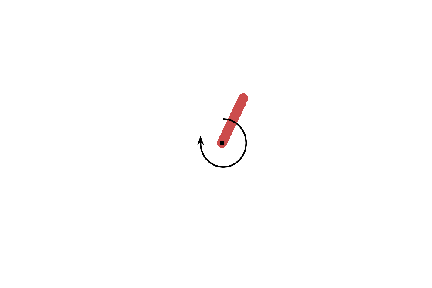
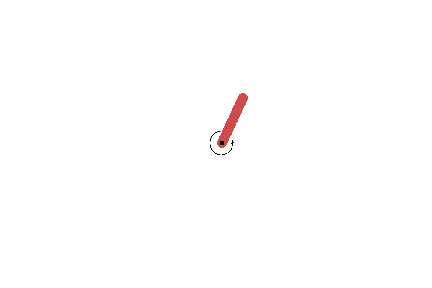
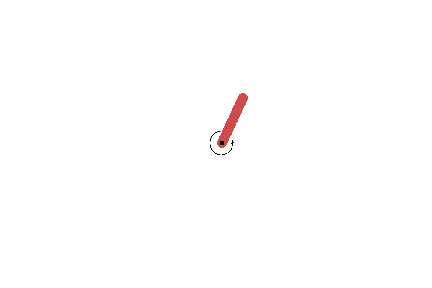
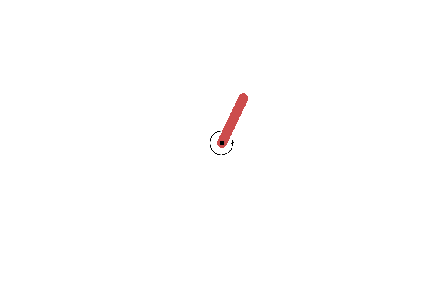
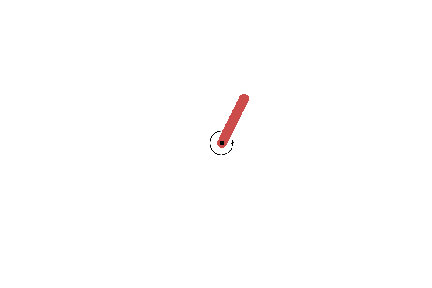
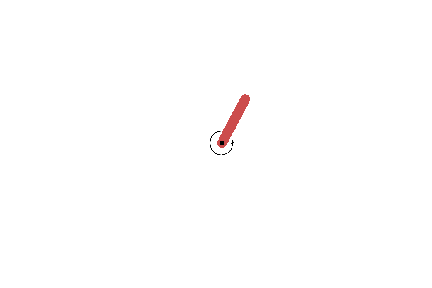
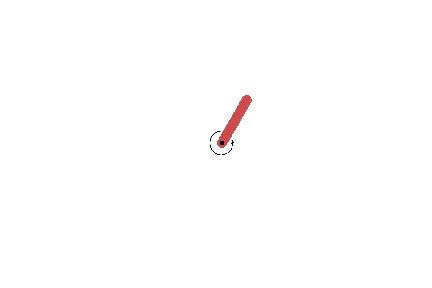
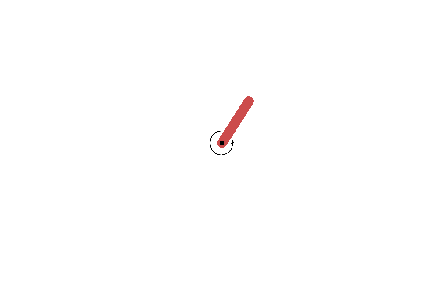
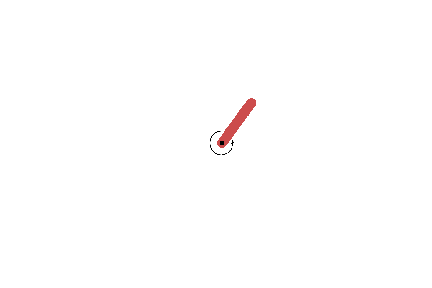
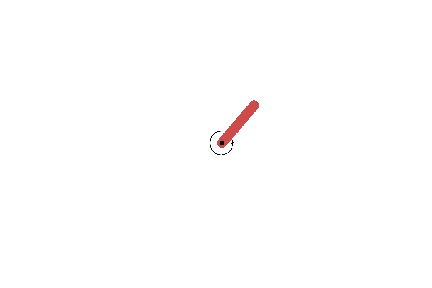
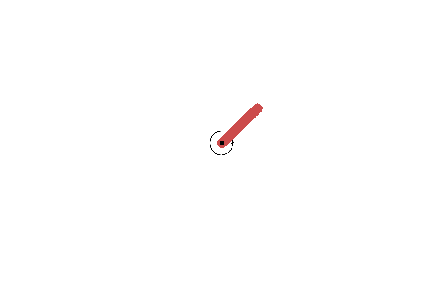
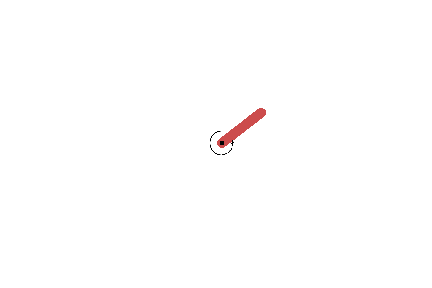
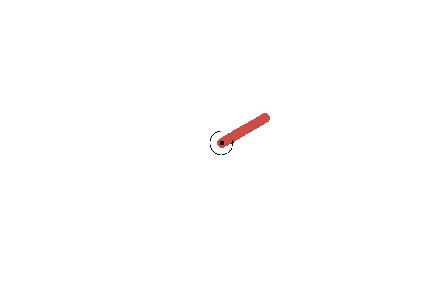
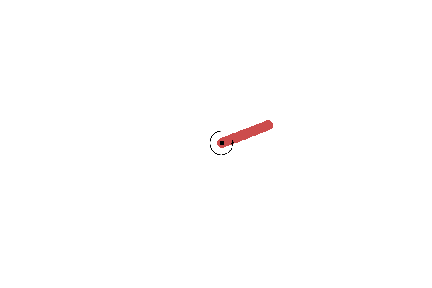
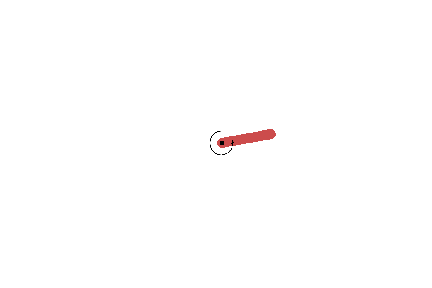
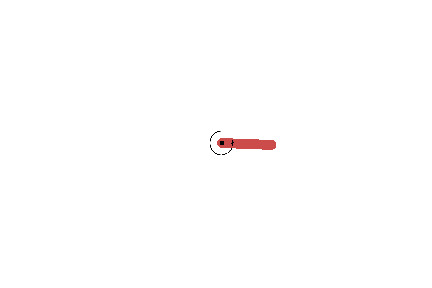
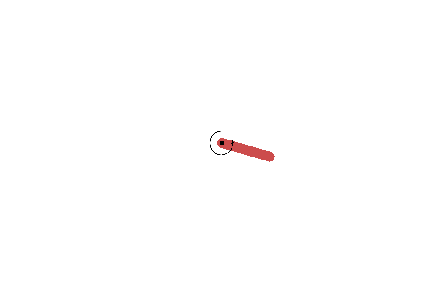
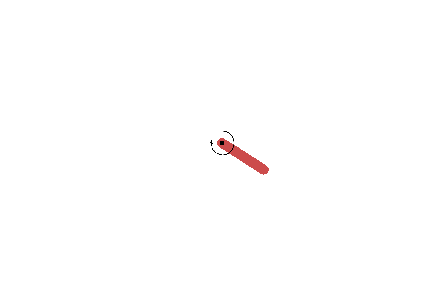
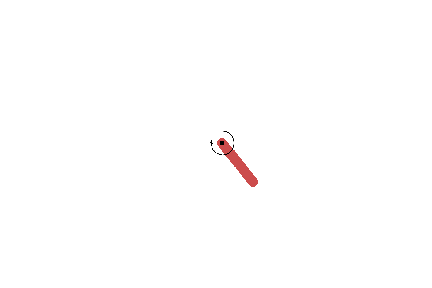
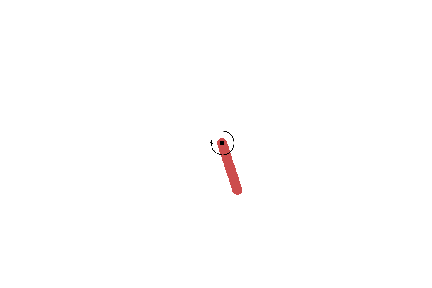
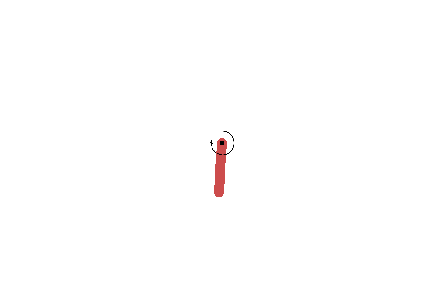
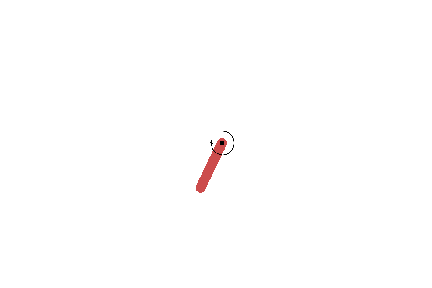
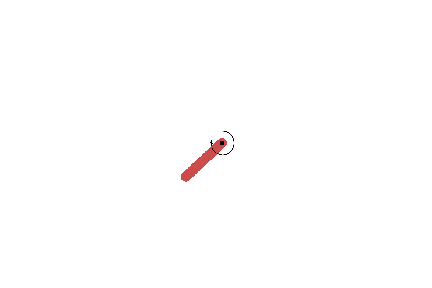
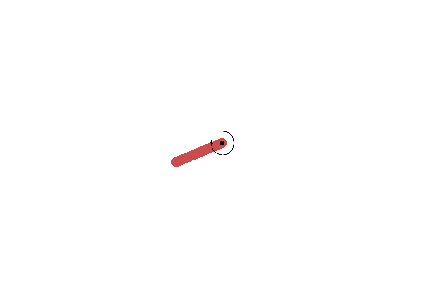
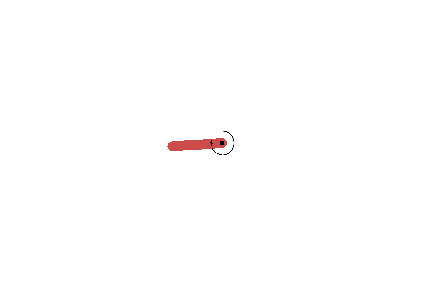
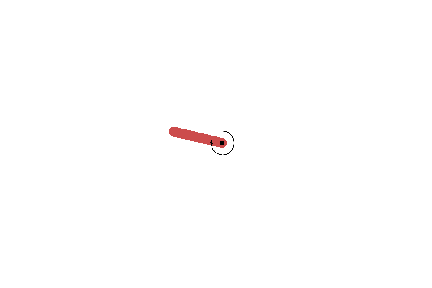
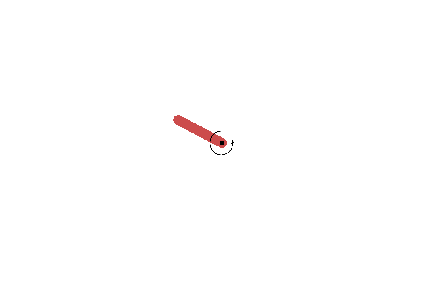
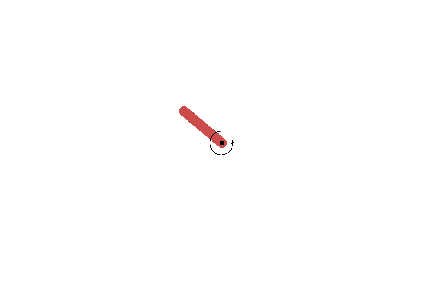
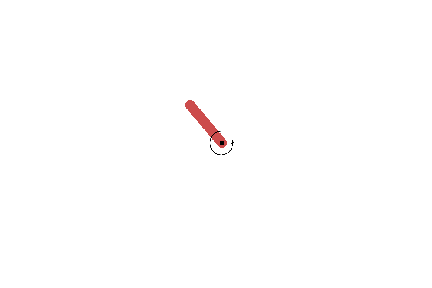
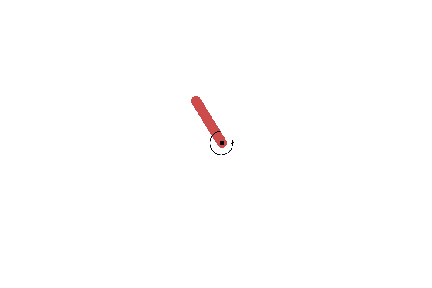
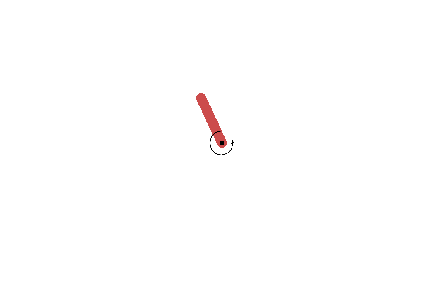
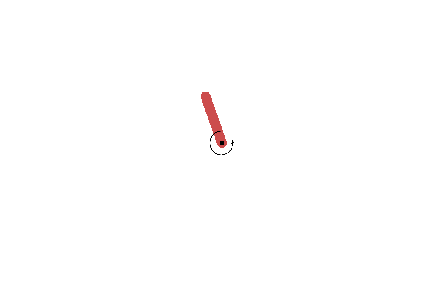
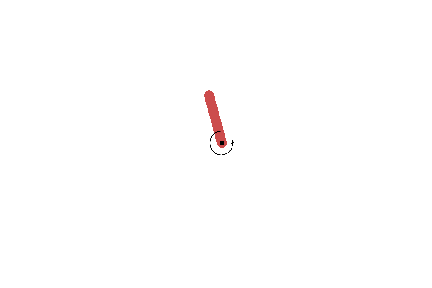
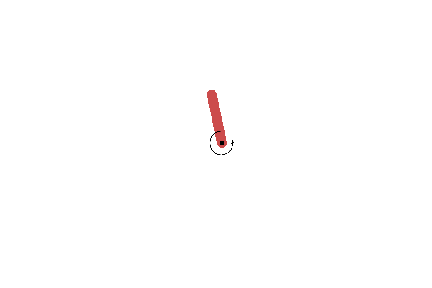
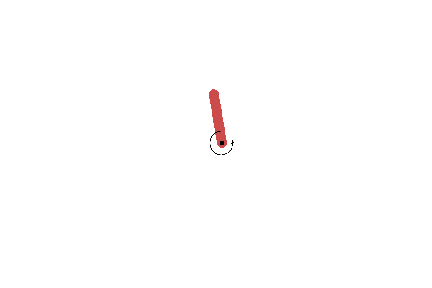
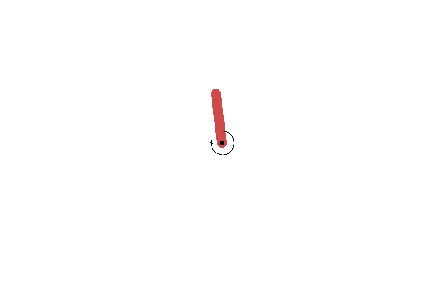
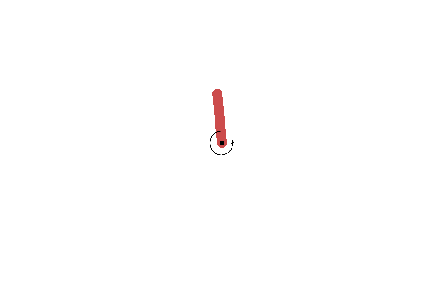
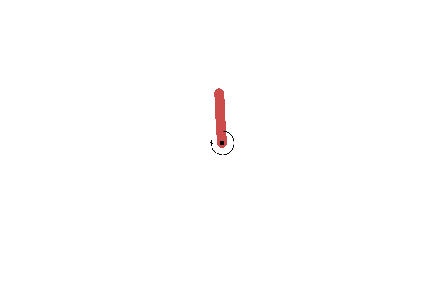
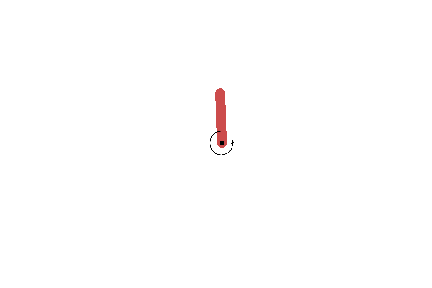
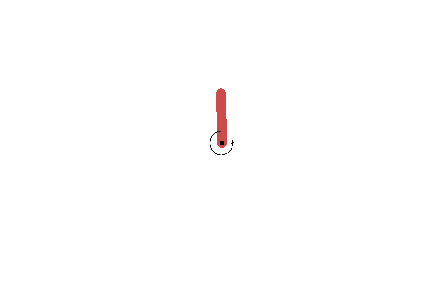
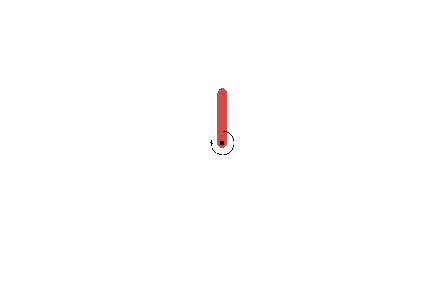
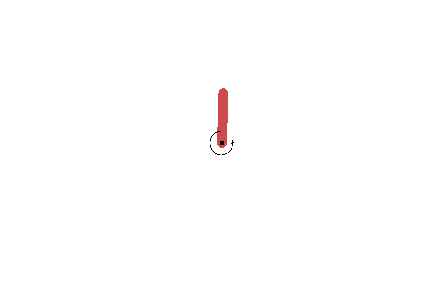
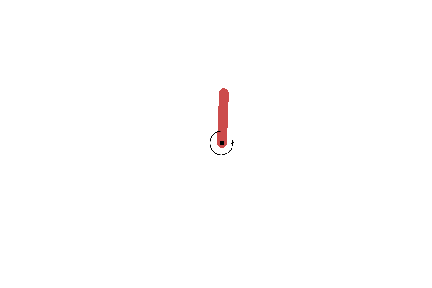
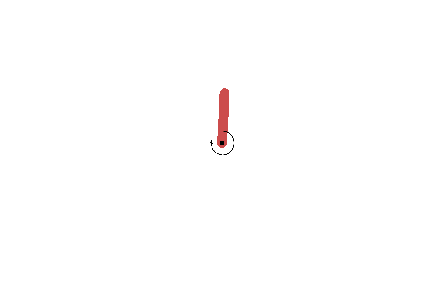
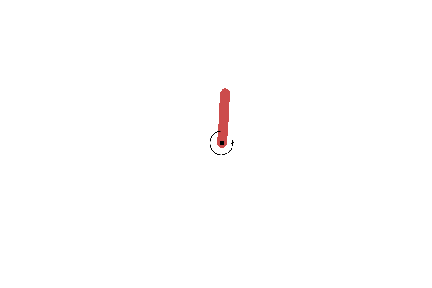
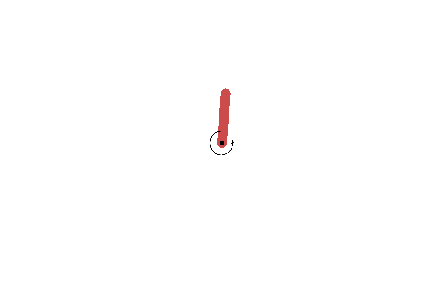
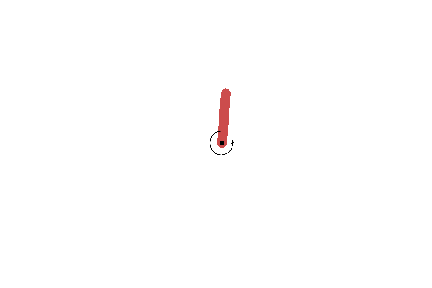
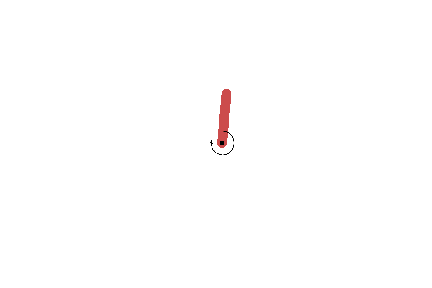
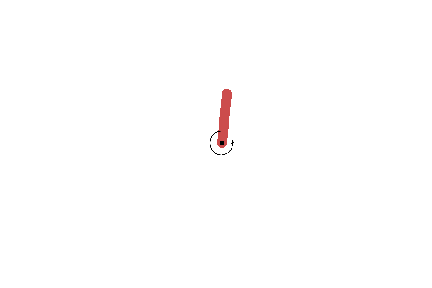
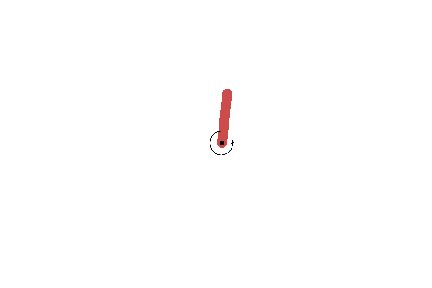
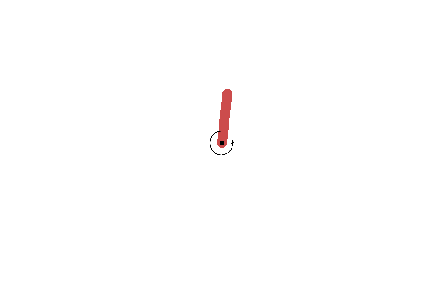
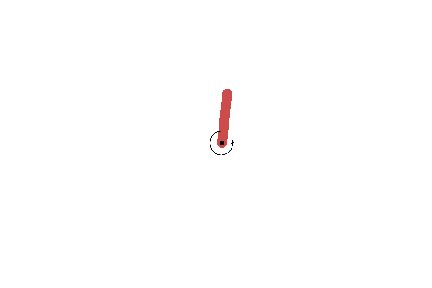
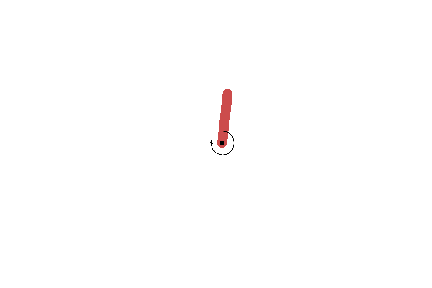
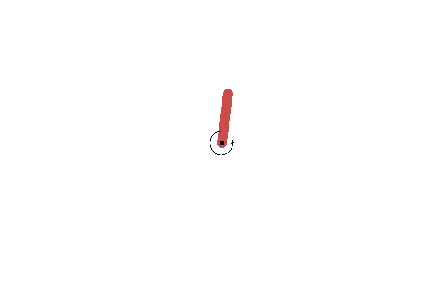
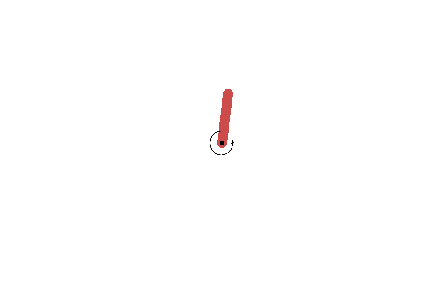
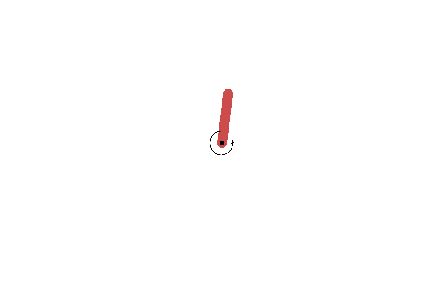
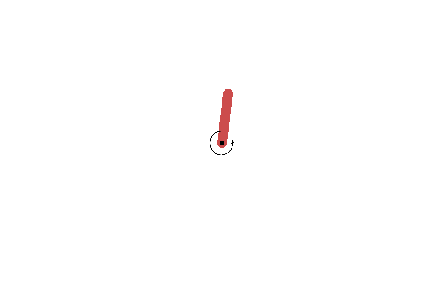
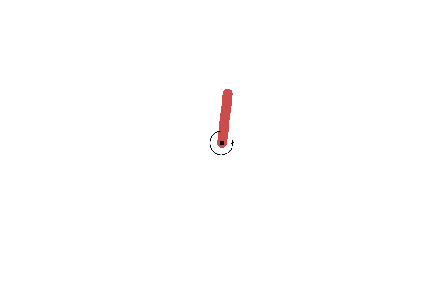
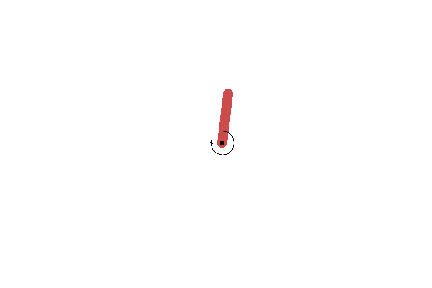
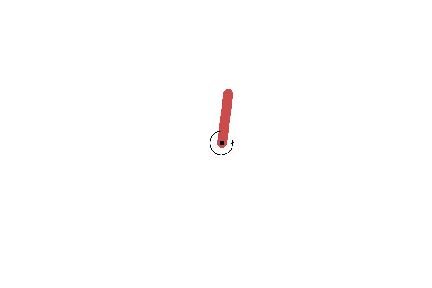
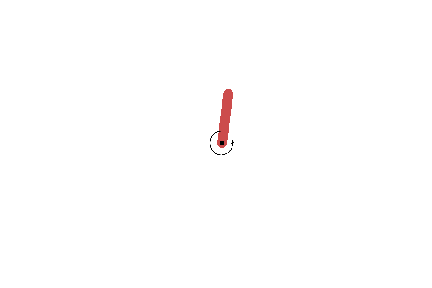
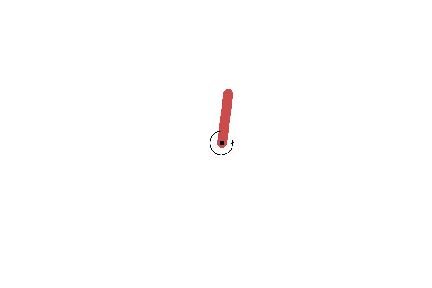
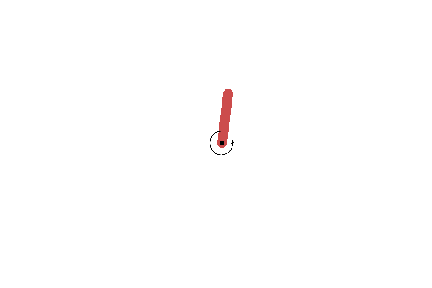
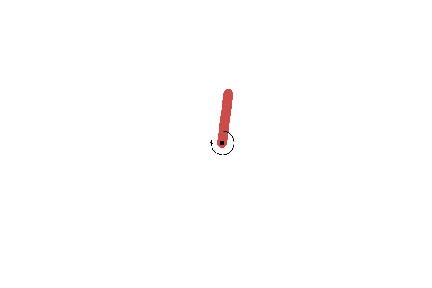
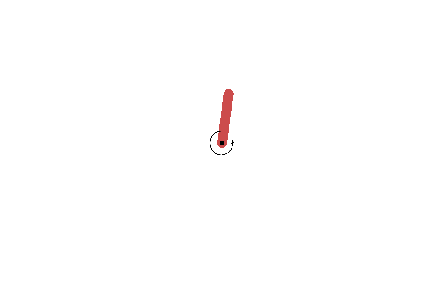
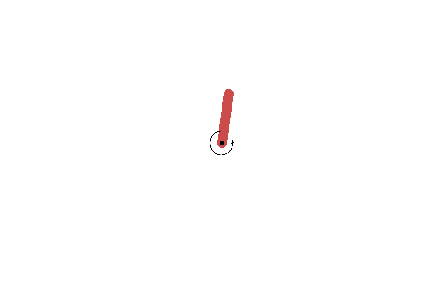
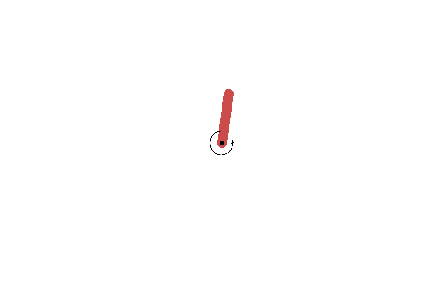
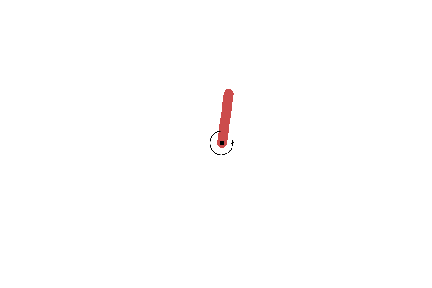
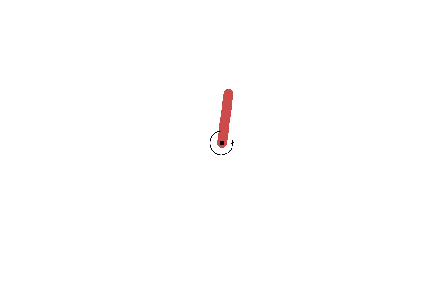
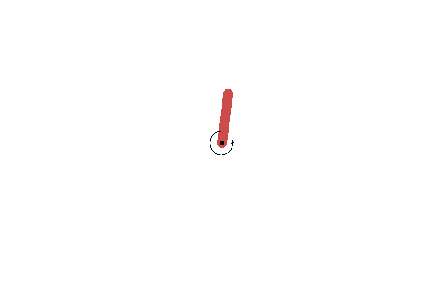
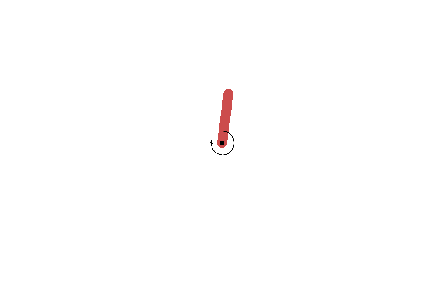
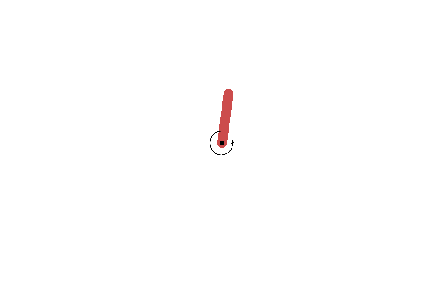
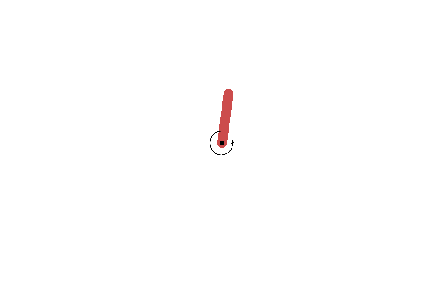
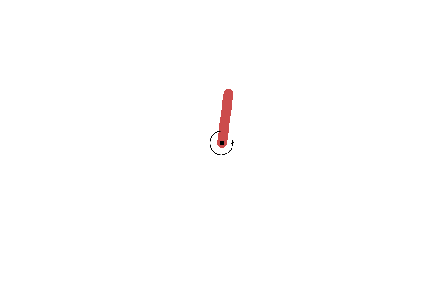
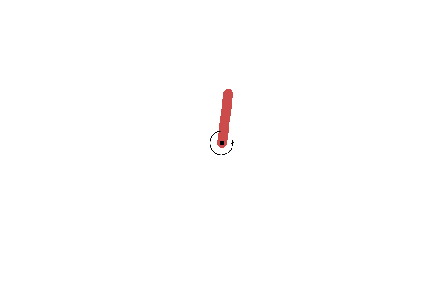
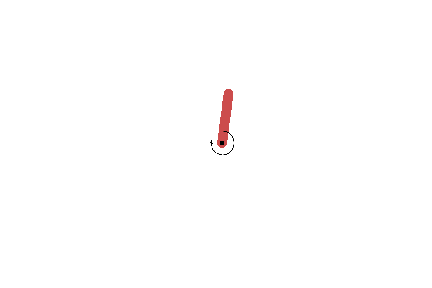
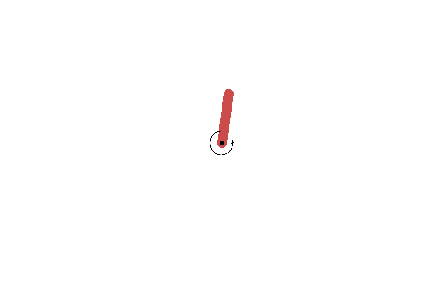
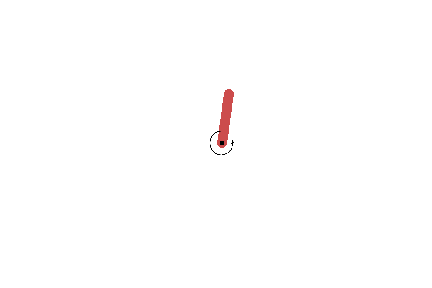
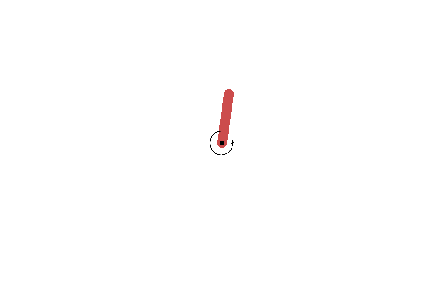
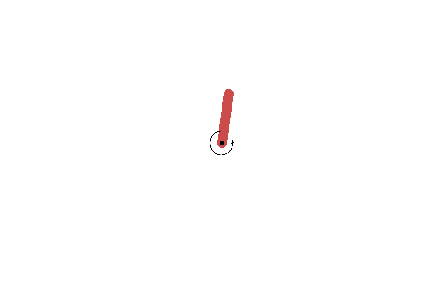
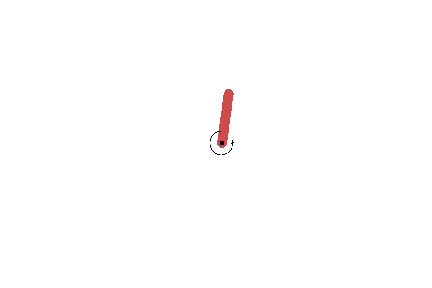
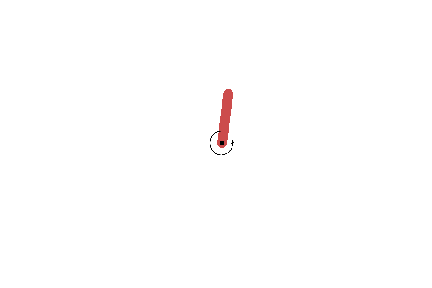
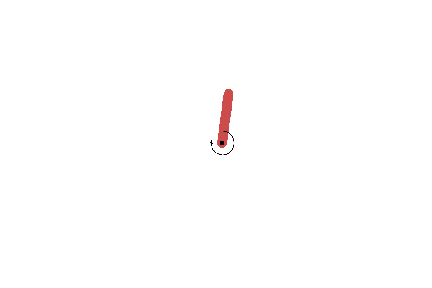
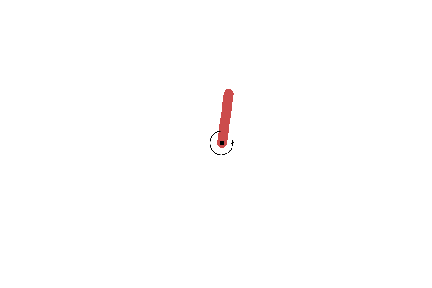
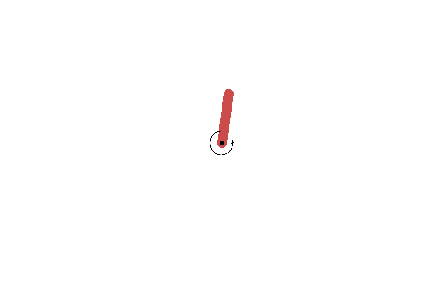
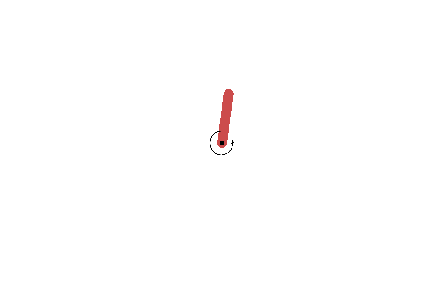
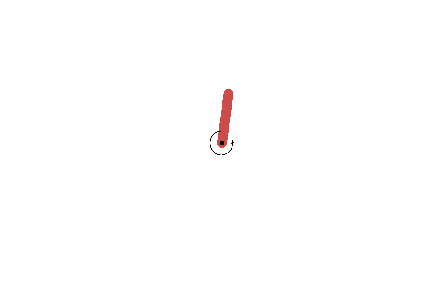
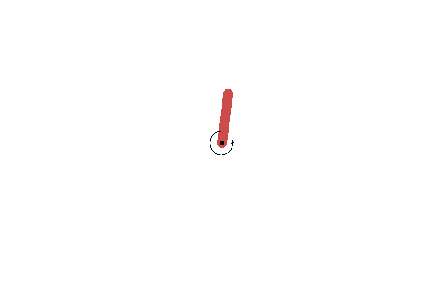
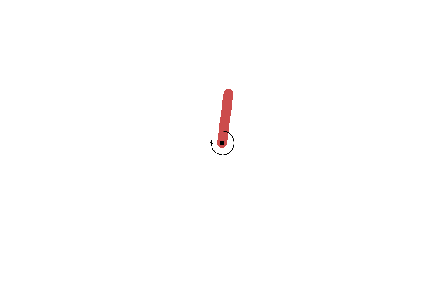
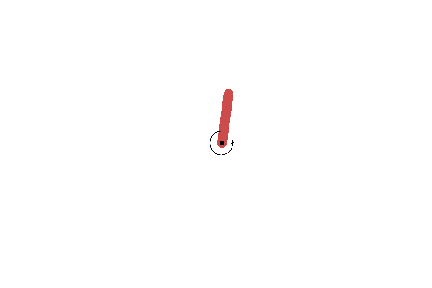
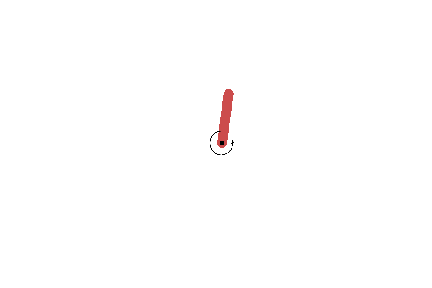
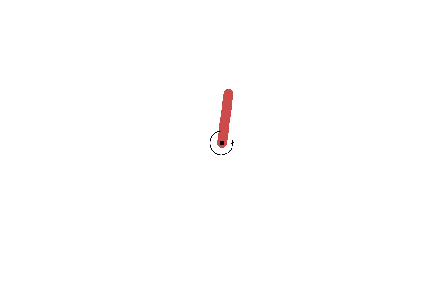
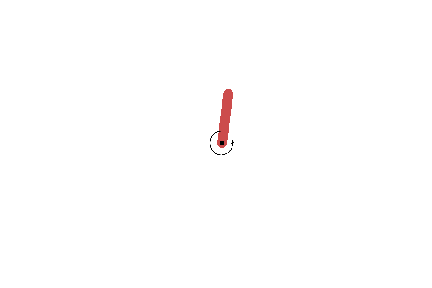
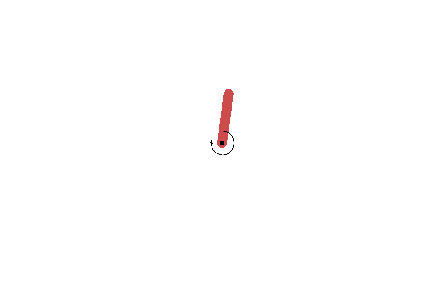
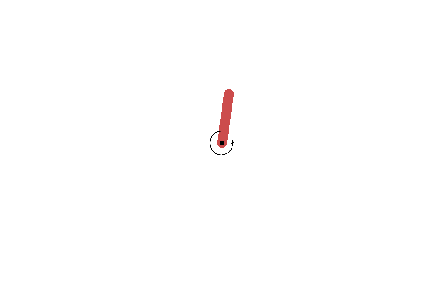
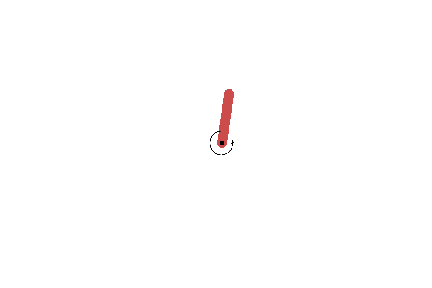
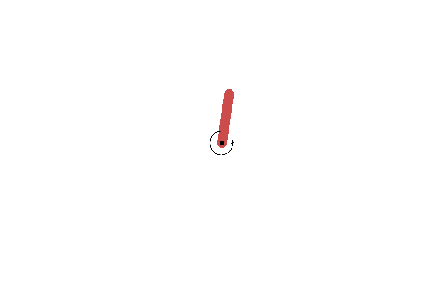
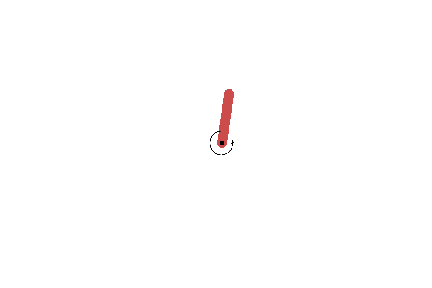
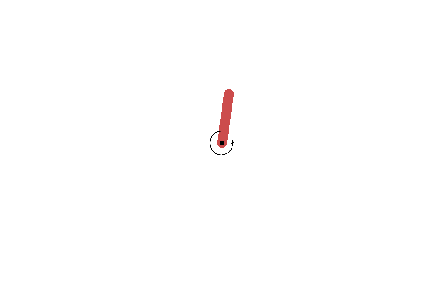
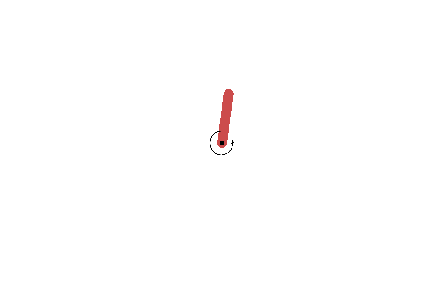
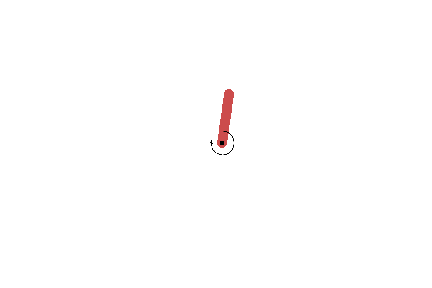
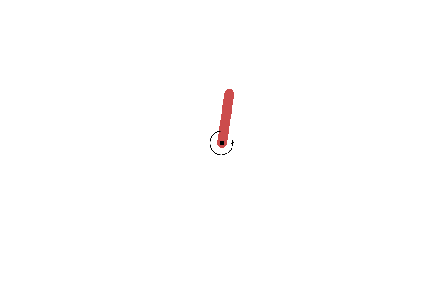
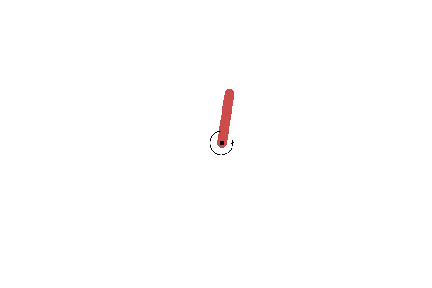
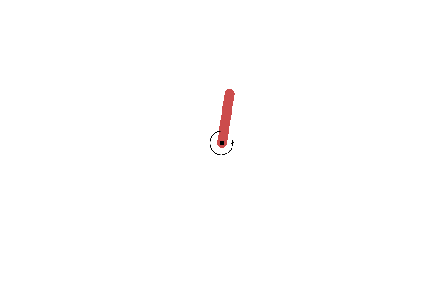
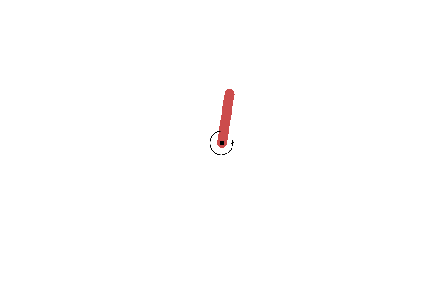
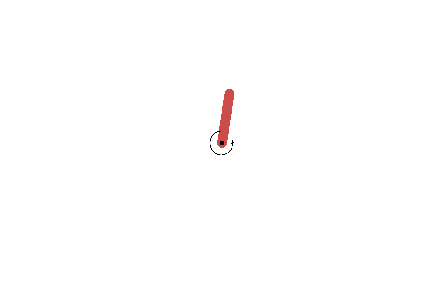
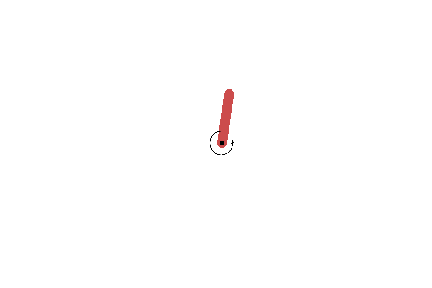
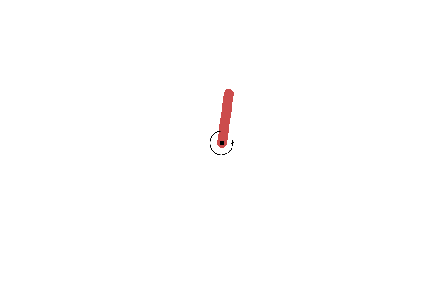
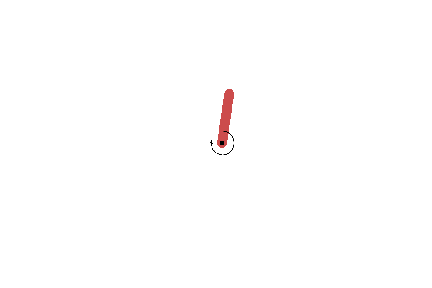
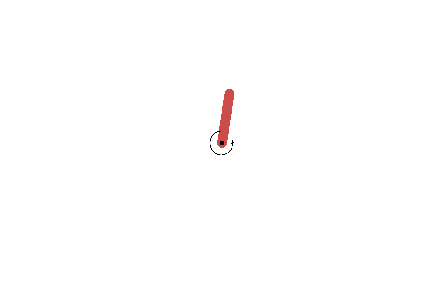
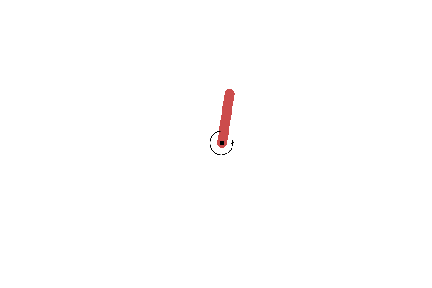
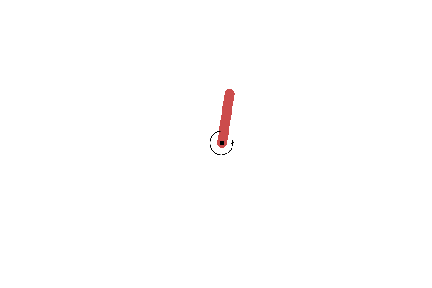
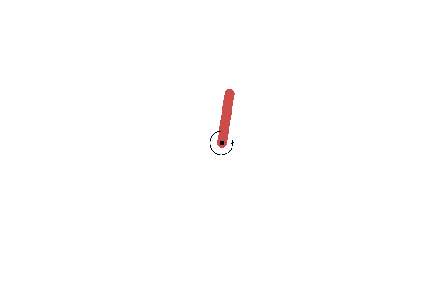
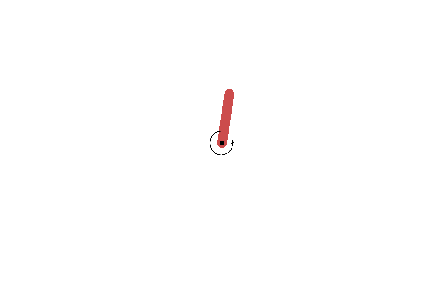
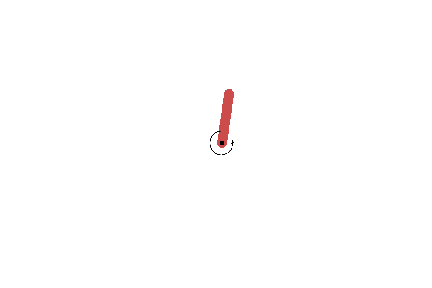
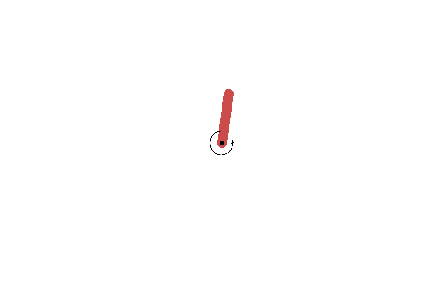
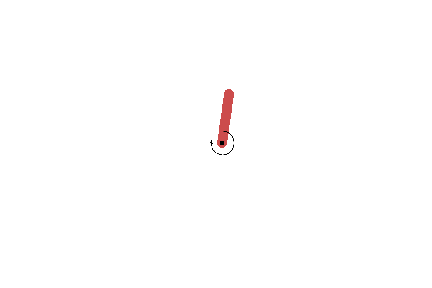
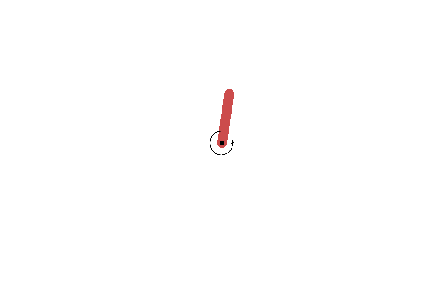
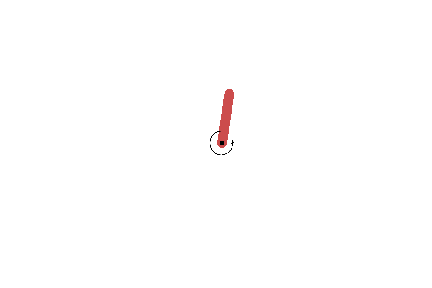
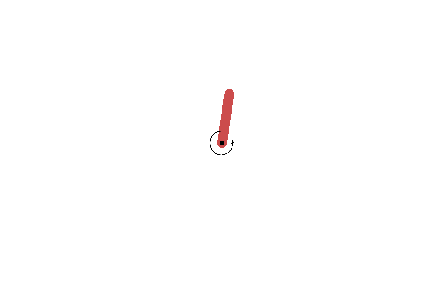
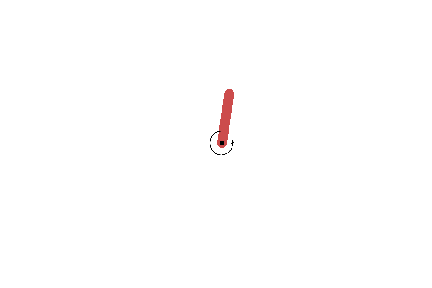
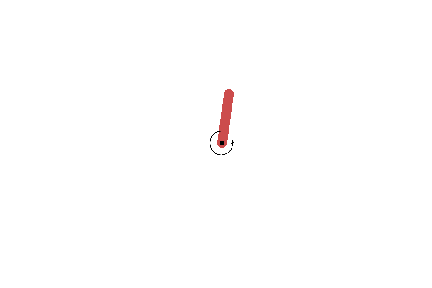
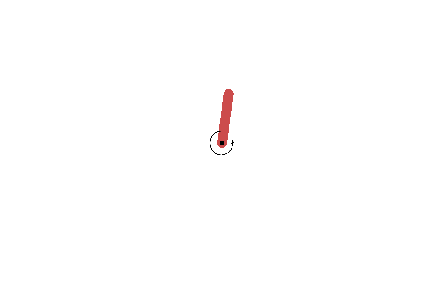
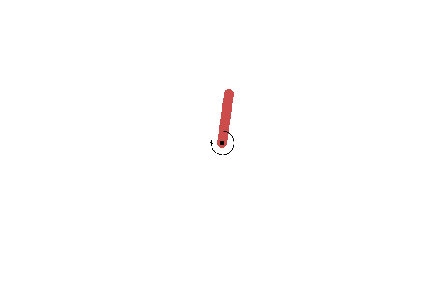
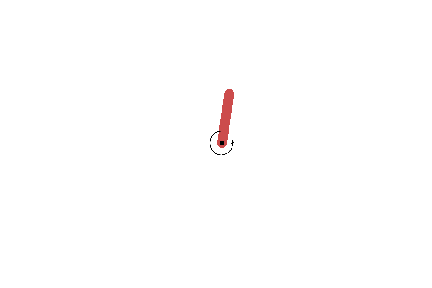
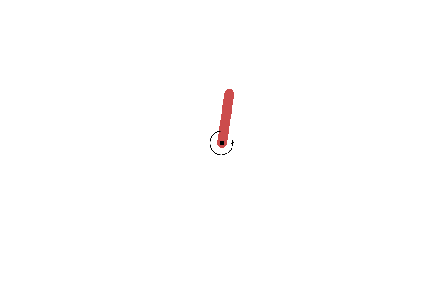
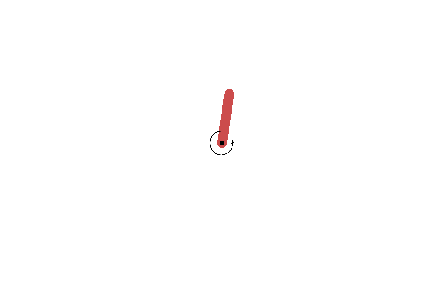
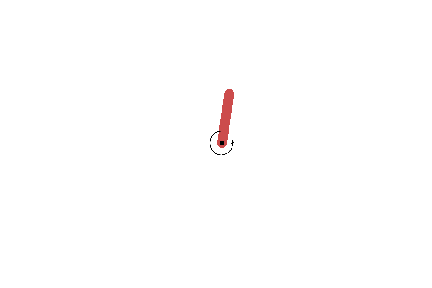
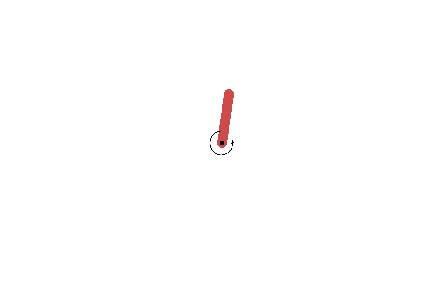
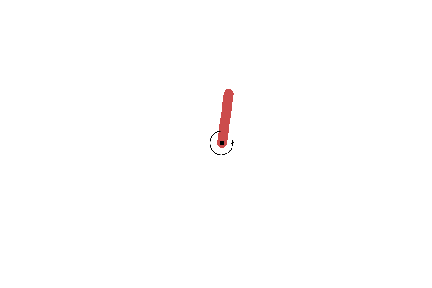
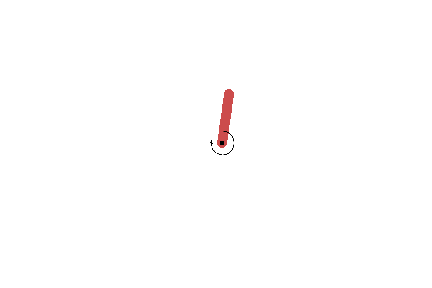
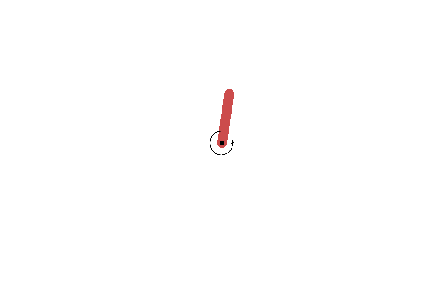
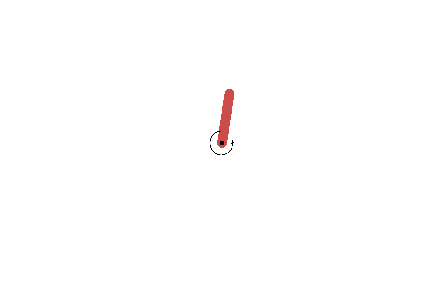
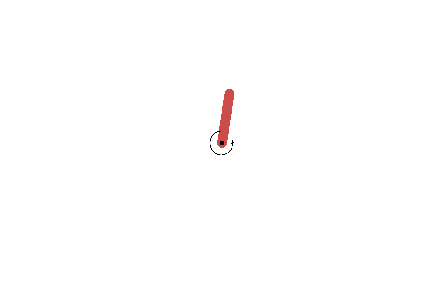
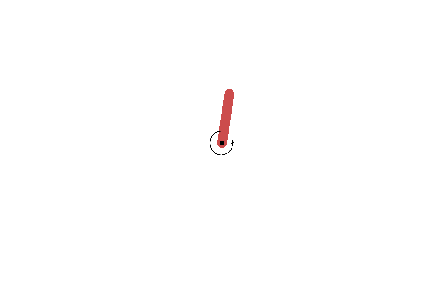
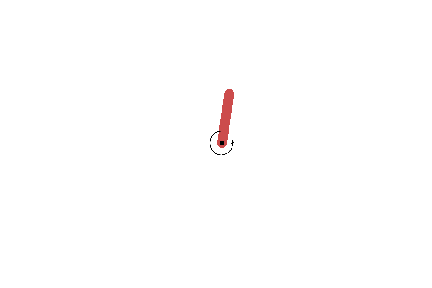
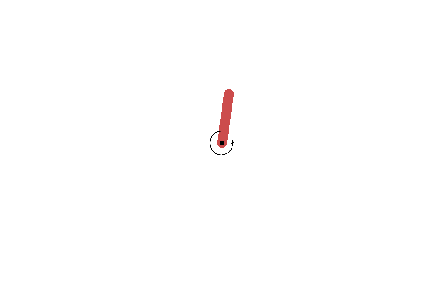
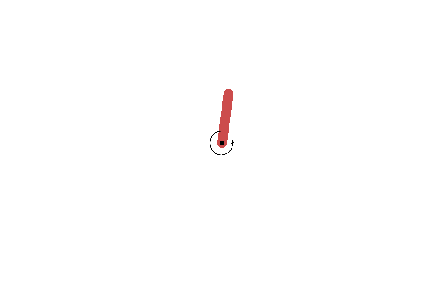
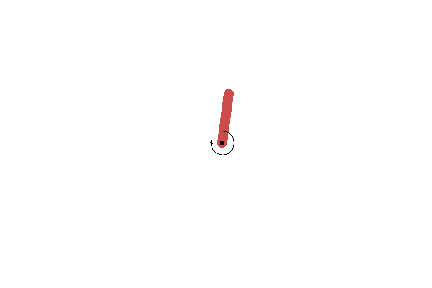
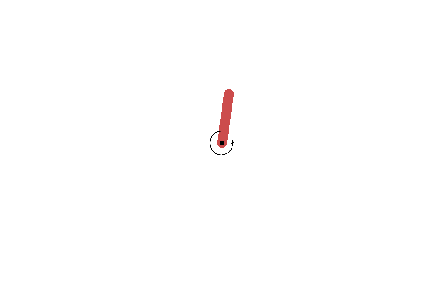
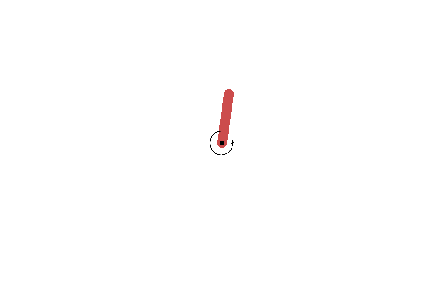
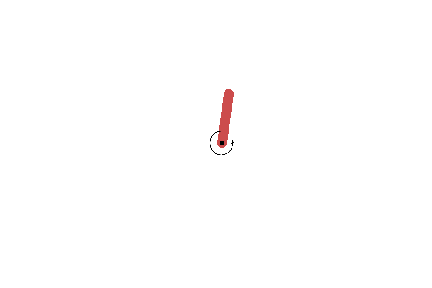
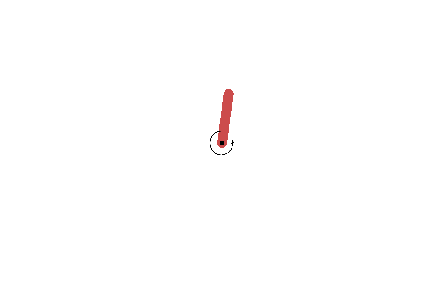
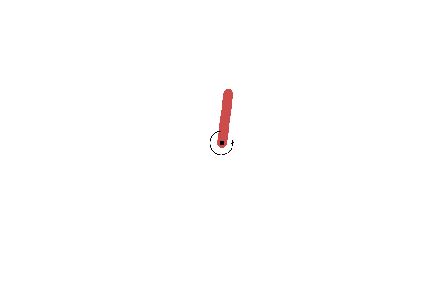
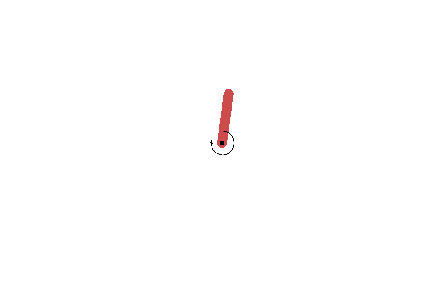
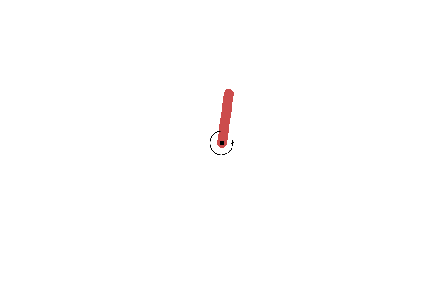
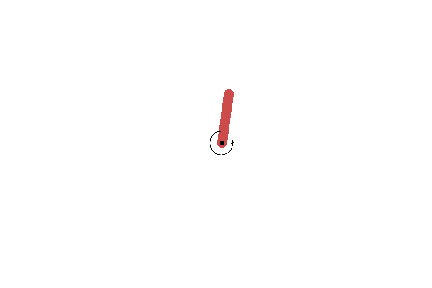
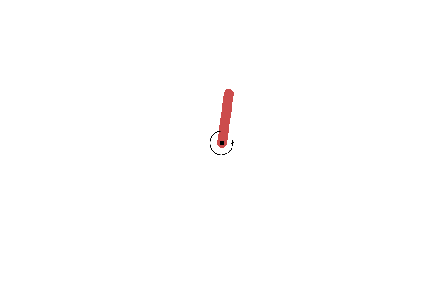
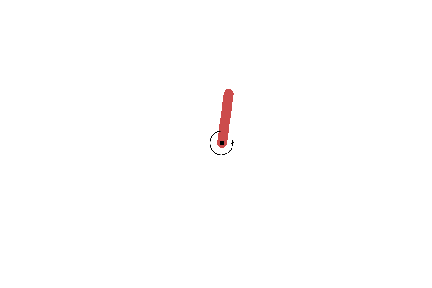
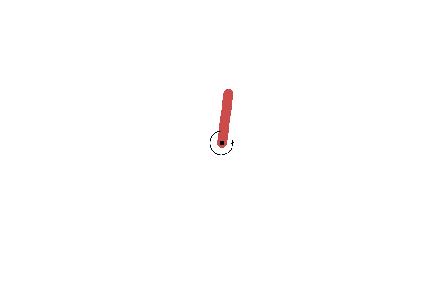
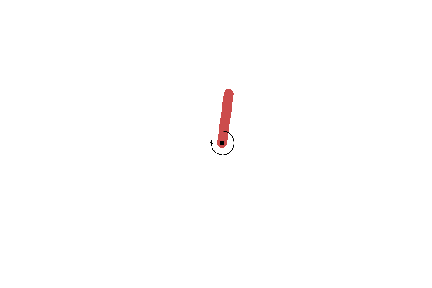
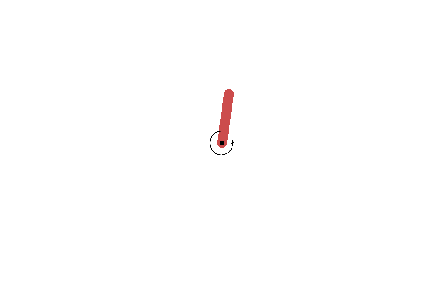
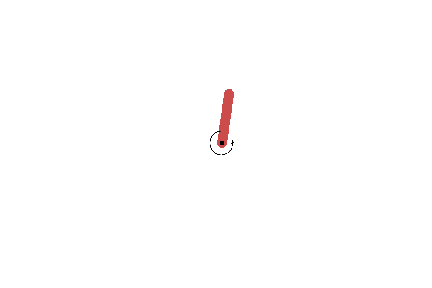
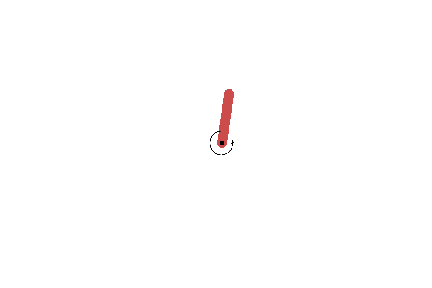
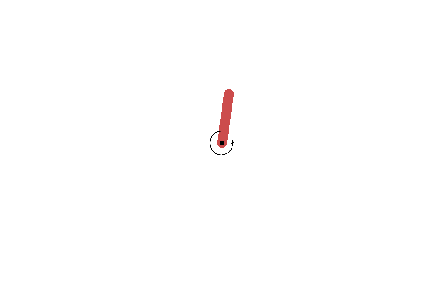
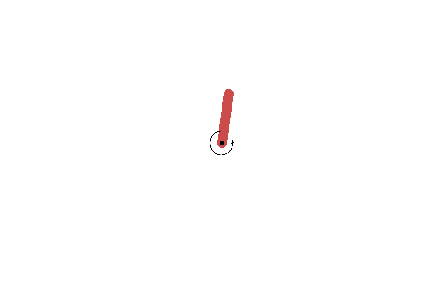
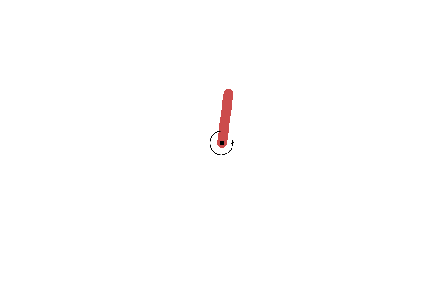
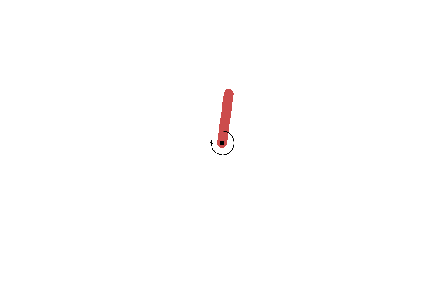
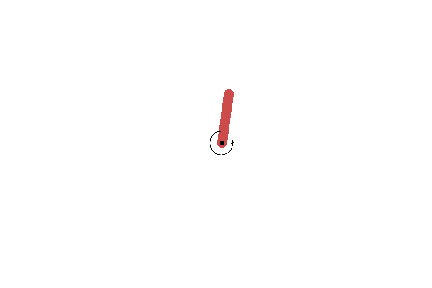
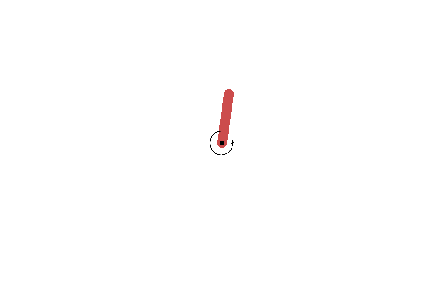
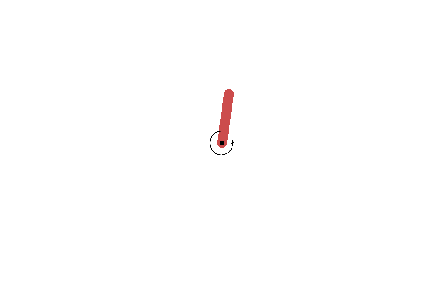
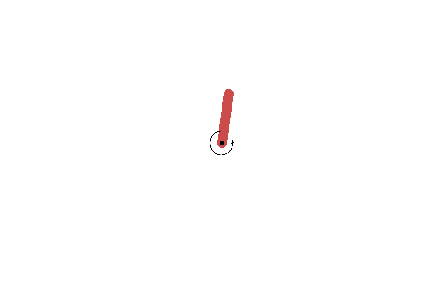
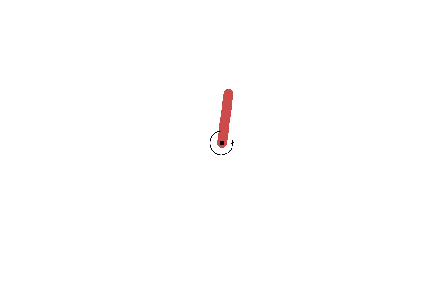
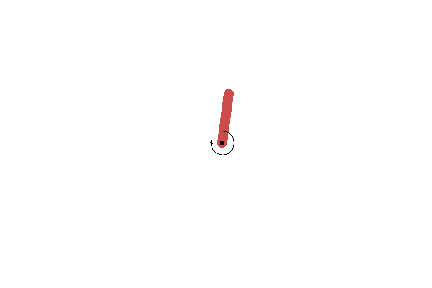
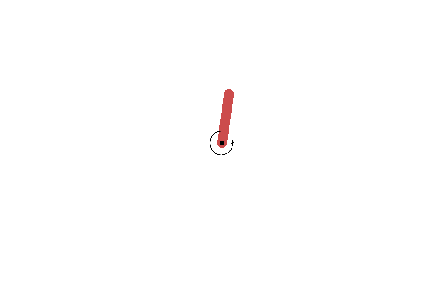
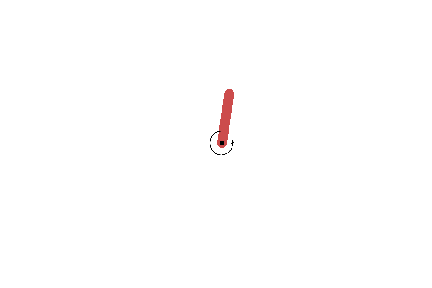
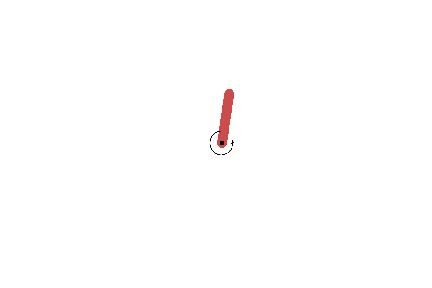
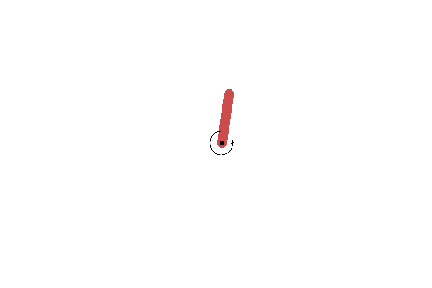
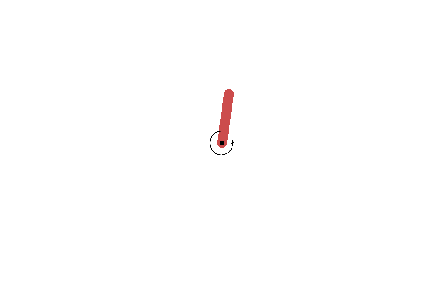
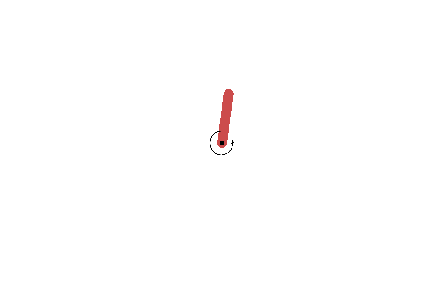
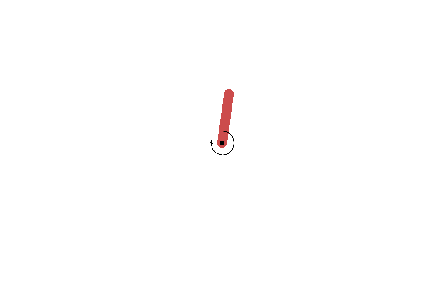
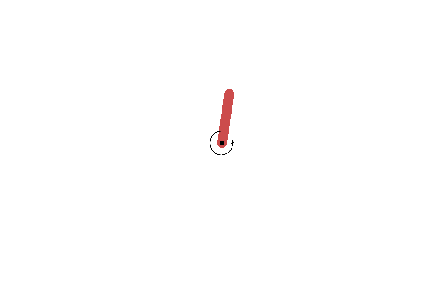
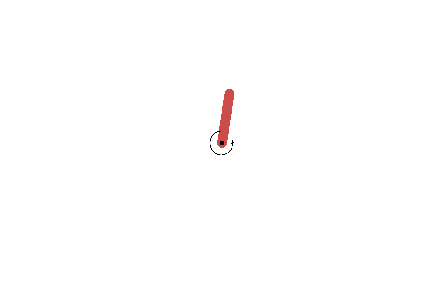
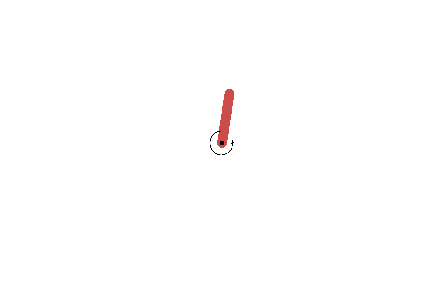
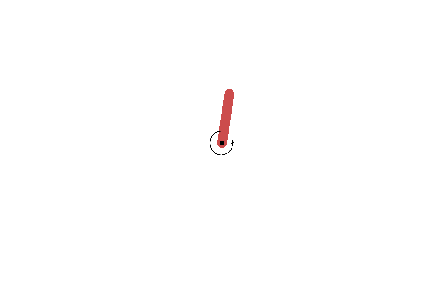
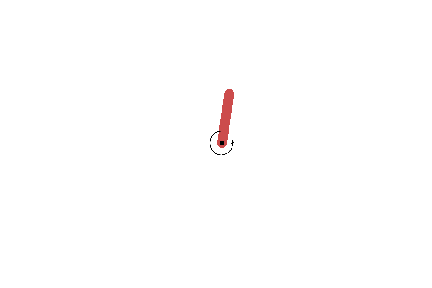
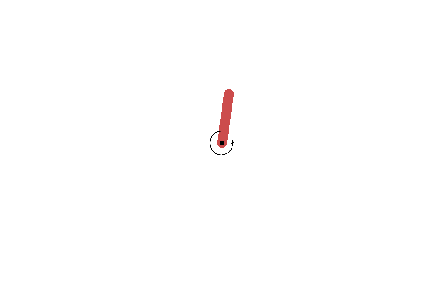
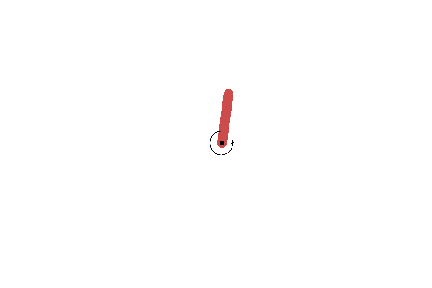
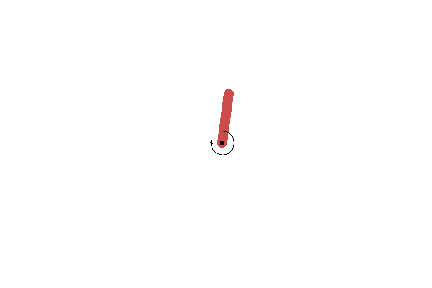
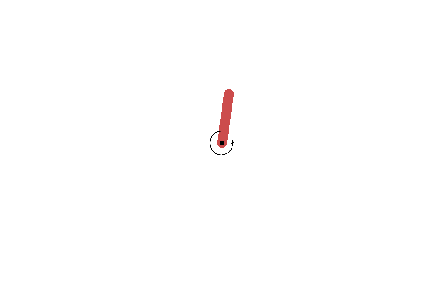
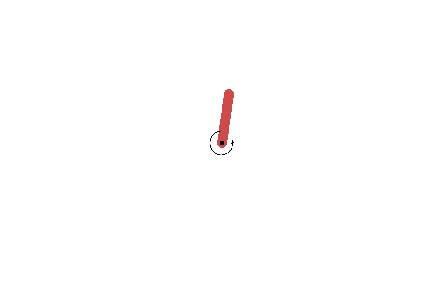
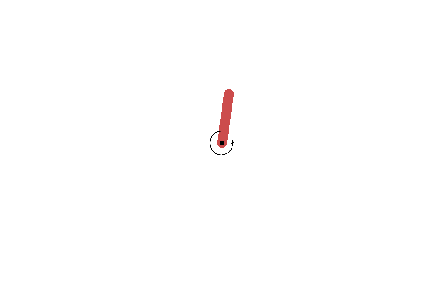
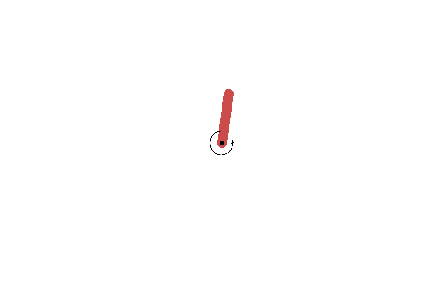
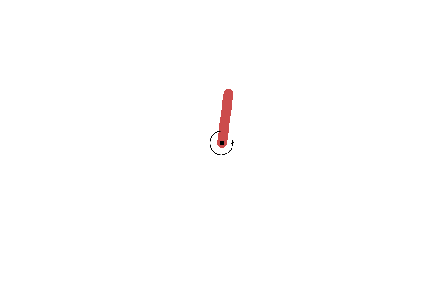
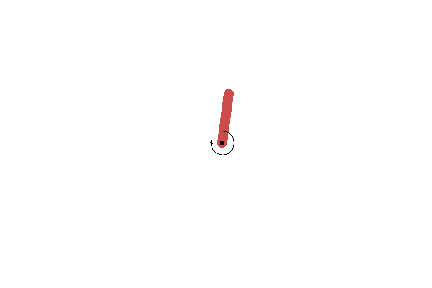
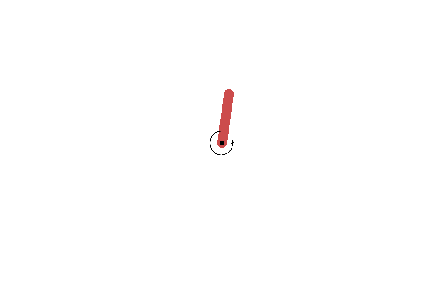
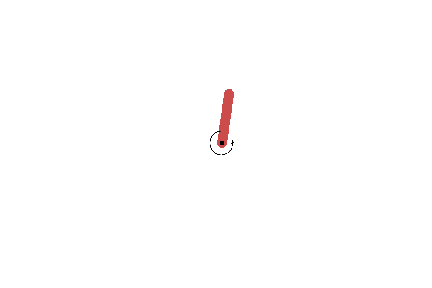
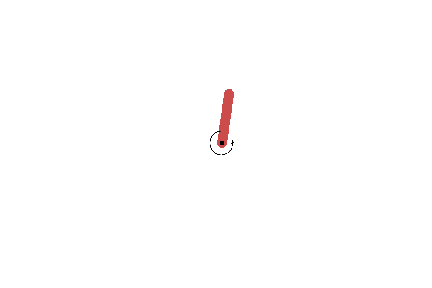
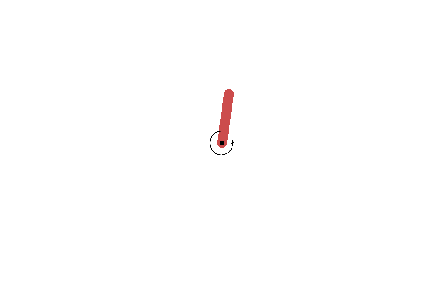
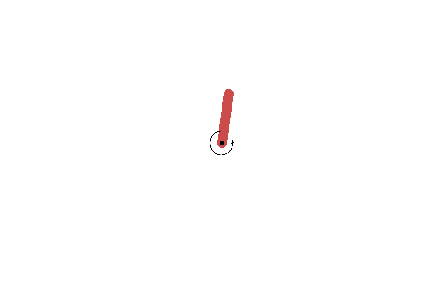
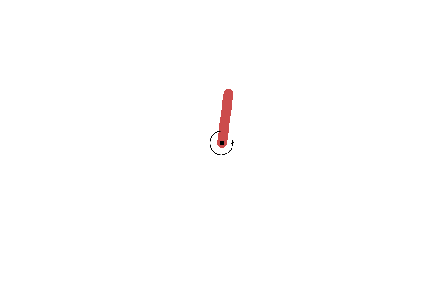
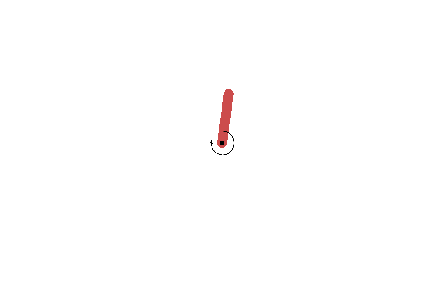
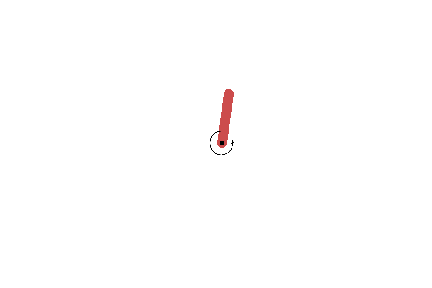
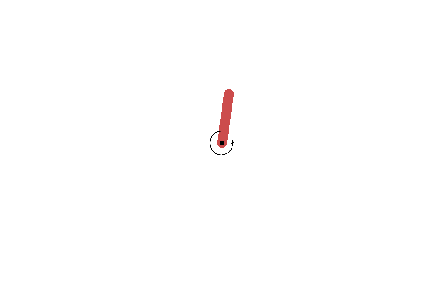
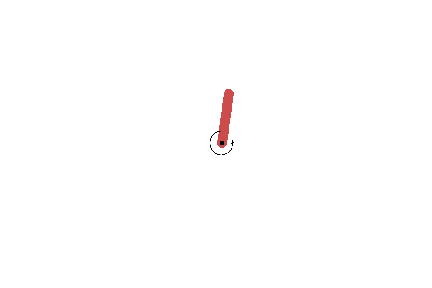
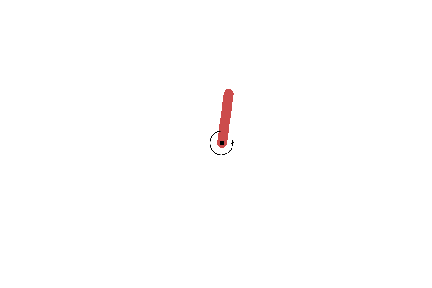
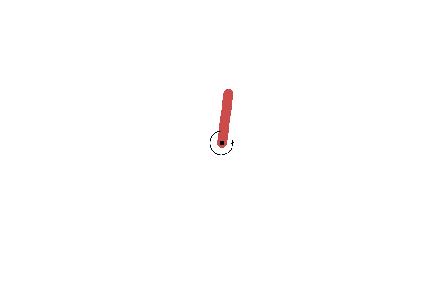
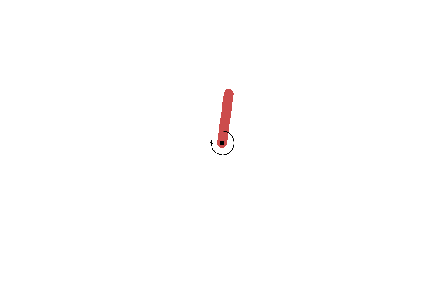
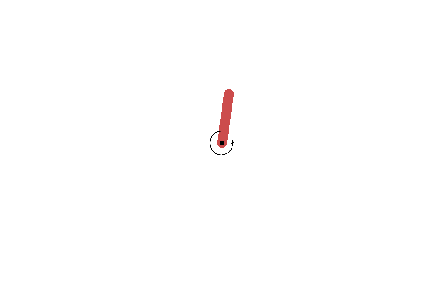
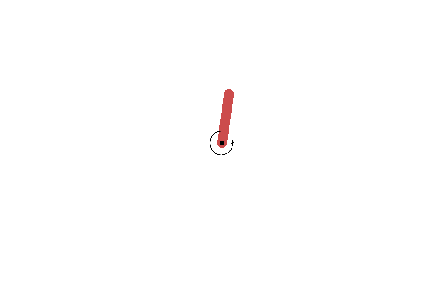

In [20]:
observation = env.reset()  # 環境はリセットする
dqn.reset_states()  # エージェントのメモリーをリセット
dqn.training = False  # 学習モードをOFF
frames = []  # 環境情報
while True:
    frames.append(env.render(mode='rgb_array'))
    action = ACT2VAL[dqn.forward(observation)]
    observation, reward, done, info = env.step(action)
    if done:
        break
env.close()
display_frames_as_gif(frames)